In [58]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn import preprocessing

In [2]:
def CDS_code_maker(CC, DC, SC):
    if len(str(int(CC)))<2:
        CC = '0'+ str(int(CC))
    else:
        CC = str(int(CC))
    DC = str(int(DC))
    if len(str(int(SC)))<7:
        SC = '0'*(7-len(str(int(SC))))+ str(int(SC))
    else:
        SC = str(int(SC))
    if len(CC+DC+SC) != 14:
        print(CC+DC+SC)
    return CC+DC+SC#, CC, DC, SC

In [3]:
path = 'CA_edu_data/'

In [4]:
numeric = ['CohortStudents', 'RegularHSGradCount',
       'RegularHSGradRate', 'MetUCCSUCount', 'MetUCCSURate',
       'SealOfBiliteracyCount', 'SealOfBiliteracyRate',
       'GoldenStateSealMeritCount', 'GoldenStateSealMeritRate',
       'CHSPECompleterCount', 'CHSPECompleterRate', 'AdultEdDiplomaCount',
       'AdultEdDiplomaRate', 'SPEDCertificateCount', 'SPEDCertificateRate',
       'GEDCompleterCount', 'GEDCompleterRate', 'OtherTransferCount',
       'OtherTransferRate', 'DropoutCount', 'DropoutRate',
       'StillEnrolledCount', 'StillEnrolledRate']

In [5]:
grad_rates = pd.read_table(path+'grad_rates_cohort1617.txt', sep = '\t')
grad_rates = grad_rates[(grad_rates.AggLevel == 'S') & (grad_rates.DASSYN == 'No')& (grad_rates.CharterYN != 'All')]
grad_rates['CDS'] = [CDS_code_maker(grad_rates.CountyCode.iloc[ik], grad_rates.DistrictCode.iloc[ik], grad_rates.SchoolCode.iloc[ik]) for ik in range(len(grad_rates))]
grad_rates.reset_index()
grad_rates.set_index('CDS')

for col in numeric:
    try: 
        grad_rates[col] = grad_rates[col].str.replace("*", "0")
    except:
        print('no dice')
    grad_rates[col] = pd.to_numeric(grad_rates[col])

In [6]:
schools = grad_rates.groupby('CDS')
repcats = grad_rates.groupby('ReportingCategory')

In [7]:
repcat_cols = ['CohortStudents', 'RegularHSGradCount','RegularHSGradRate', 'MetUCCSUCount', 'MetUCCSURate','DropoutCount', 'DropoutRate']
# gradmeta_cols = ['CountyName', 'DistrictName', 'SchoolName','CDS', 'CharterYN']

In [8]:
grad_rates2 = grad_rates[['CDS', 'CharterYN', 'CountyCode', 'DistrictCode', 'SchoolCode']].drop_duplicates()

for repcat in repcats:
    sub_df = repcat[1][['CDS']]
    sub_df.set_index(['CDS'])
    for col in repcat_cols:
        sub_df[col+ '_' + repcat[0]] = repcat[1][col]
    grad_rates2 = grad_rates2.join(sub_df.set_index(['CDS'], verify_integrity=True), on = ['CDS'], how = 'outer')

grad_rates2.reset_index()
grad_rates2 = grad_rates2.set_index(['CDS'])

# grad_rates2['CohortStudents_All'] = grad_rates2.CohortStudents_GF + grad_rates2.CohortStudents_GM

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
grad_rates2['CohortStudents_All'] = grad_rates2.CohortStudents_GF + grad_rates2.CohortStudents_GM
# grad_rates2['RegularHSGradCount_All'] = grad_rates2.RegularHSGradCount_GF + grad_rates2.RegularHSGradCount_GM
# grad_rates2['MetUCCSUCount_All'] = grad_rates2.MetUCCSUCount_GF + grad_rates2.MetUCCSUCount_GM
# grad_rates2['RegularHSGradRate_All'] = grad_rates2.RegularHSGradCount_All / grad_rates2.CohortStudents_All
# grad_rates2['MetUCCSURate_All'] = grad_rates2.MetUCCSUCount_All / grad_rates2.CohortStudents_All

In [10]:
grad_rates2 = grad_rates2.drop(['CharterYN'], axis= 1)

In [11]:
def split_GS(grades_vect):

    def splitter(offered):
        try:
            [min_grade, max_grade] = offered.split('-')
            if min_grade == 'K':
                min_grade = 0
            if float(max_grade)>12:
                max_grade = 13
        except:
            [min_grade, max_grade] = [np.nan, np.nan]
        return min_grade, max_grade

    min_grdes = []
    max_grdes = []
    for ik in range(len(grades_vect)):
        min_grade, max_grade = splitter(grades_vect[ik])
        min_grdes.append(float(min_grade))
        max_grdes.append(float(max_grade))
        
    return min_grdes, max_grdes

In [12]:
school_meta = pd.read_table(path + 'pubschls.txt', sep = '\t')
school_meta = school_meta.rename(columns={'CDSCode':'CDS'})
school_meta['CDS'] = school_meta['CDS'].astype(str)#.apply(str)

In [13]:
HS = school_meta[(school_meta.EdOpsCode == 'TRAD') & 
                 (school_meta.EILCode == 'HS') & 
                 (school_meta.StatusType == 'Active')]

In [14]:
for ik in HS.index:
    if len(HS['CDS'][ik])<14:
        repl = '0'*(14-len(HS['CDS'][ik])) + HS['CDS'][ik]
        HS['CDS'][ik] = repl

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
HS['CharterYN'] = [1 if school== 'Y' else 0 for school in HS.Charter]
HS['MagnetYN'] = [1 if school== 'Y' else 0 for school in HS.Magnet]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
len(HS['CharterYN']), len(HS.Charter)

(1365, 1365)

In [17]:
meta_cols = ['CDS', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'City', 'Zip', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'Latitude', 'Longitude', 'CharterYN', 'MagnetYN']

In [18]:
_HS = HS

In [357]:
# HS = _HS

In [19]:
meta_cols = ['CDS', 'District', 'OpenDate',
             'CharterYN', 'MagnetYN', 'GSoffered', 'GSserved']

In [20]:
HS = HS[meta_cols]
HS.reset_index()
HS = HS.set_index('CDS')

In [21]:
min_grades, max_grades = split_GS(HS.GSoffered)
HS['GSoffered_min'] = min_grades
HS['GSoffered_max'] = max_grades

min_grades, max_grades = split_GS(HS.GSserved)
HS['GSserved_min'] = min_grades
HS['GSserved_max'] = max_grades

In [22]:
HS = HS[(HS.GSserved_min==9) & (HS.GSserved_max==12)]

In [23]:
HS = HS.join(grad_rates2, how= 'left')

In [24]:
EL_numeric = ['KDGN', 'GR_1',
       'GR_2', 'GR_3', 'GR_4', 'GR_5', 'GR_6', 'GR_7', 'GR_8', 'GR_9', 'GR_10',
       'GR_11', 'GR_12', 'UNGR', 'TOTAL_EL']

In [25]:
EL = pd.read_csv(path+ 'eng_learn1617_corr.csv')
for col in EL_numeric:
    EL[col] = pd.to_numeric(EL[col])
    
EL['CDS'] = EL['CDS'].apply(str)
EL.reset_index()
EL = EL.set_index(['CDS'])


In [99]:
HS.columns[:50]

Index(['District', 'OpenDate', 'CharterYN', 'MagnetYN', 'GSoffered',
       'GSserved', 'GSoffered_min', 'GSoffered_max', 'GSserved_min',
       'GSserved_max', 'CountyCode', 'DistrictCode', 'SchoolCode',
       'CohortStudents_GF', 'RegularHSGradCount_GF', 'RegularHSGradRate_GF',
       'MetUCCSUCount_GF', 'MetUCCSURate_GF', 'DropoutCount_GF',
       'DropoutRate_GF', 'CohortStudents_GM', 'RegularHSGradCount_GM',
       'RegularHSGradRate_GM', 'MetUCCSUCount_GM', 'MetUCCSURate_GM',
       'DropoutCount_GM', 'DropoutRate_GM', 'CohortStudents_GN',
       'RegularHSGradCount_GN', 'RegularHSGradRate_GN', 'MetUCCSUCount_GN',
       'MetUCCSURate_GN', 'DropoutCount_GN', 'DropoutRate_GN',
       'CohortStudents_RA', 'RegularHSGradCount_RA', 'RegularHSGradRate_RA',
       'MetUCCSUCount_RA', 'MetUCCSURate_RA', 'DropoutCount_RA',
       'DropoutRate_RA', 'CohortStudents_RB', 'RegularHSGradCount_RB',
       'RegularHSGradRate_RB', 'MetUCCSUCount_RB', 'MetUCCSURate_RB',
       'DropoutCount_RB',

In [91]:
grad_rates2.columns

Index(['CountyCode', 'DistrictCode', 'SchoolCode', 'CohortStudents_GF',
       'RegularHSGradCount_GF', 'RegularHSGradRate_GF', 'MetUCCSUCount_GF',
       'MetUCCSURate_GF', 'DropoutCount_GF', 'DropoutRate_GF',
       ...
       'DropoutCount_SS', 'DropoutRate_SS', 'CohortStudents_TA',
       'RegularHSGradCount_TA', 'RegularHSGradRate_TA', 'MetUCCSUCount_TA',
       'MetUCCSURate_TA', 'DropoutCount_TA', 'DropoutRate_TA',
       'CohortStudents_All'],
      dtype='object', length=137)

In [26]:
EL.columns

Index(['COUNTY', 'DISTRICT', 'SCHOOL', 'LC', 'LANGUAGE', 'KDGN', 'GR_1',
       'GR_2', 'GR_3', 'GR_4', 'GR_5', 'GR_6', 'GR_7', 'GR_8', 'GR_9', 'GR_10',
       'GR_11', 'GR_12', 'UNGR', 'TOTAL_EL'],
      dtype='object')

In [197]:
# Number of languages with data
len(langs)


66

In [43]:
# EL.to_csv(path+'eng_learn1617_corr.csv')

In [26]:
lang_cols = ['GR_9', 'GR_10', 'GR_11', 'GR_12']
langs = EL.groupby('LANGUAGE')

HS2 = HS
langs_d =  {'lang' : [], 'total': []}
for lang in langs:
    sub_df = lang[1][lang_cols]
    sub_df = sub_df.reindex(columns=lang_cols+ ['ALL'])
    sub_df['ALL'] = lang[1]['GR_12']+lang[1]['GR_11']+ lang[1]['GR_10']+ lang[1]['GR_9']
    langs_d['lang'].append(lang[0])
    langs_d['total'].append(sum(sub_df['ALL']))
    sub_df = sub_df.rename(columns={col:col+ '_' + lang[0] for col in sub_df.columns})
    HS2 = HS2.join(sub_df)#.set_index(['CDS'], verify_integrity=True), on = ['CDS'], how = 'outer')
    HS2[sub_df.columns] = HS2[sub_df.columns].fillna(0)

In [27]:
# HS2['Total_EL'] = [sum([HS2[HS2.index ==ind][col][0] if 'ALL_' in col else 0 for col in HS2.columns]) for ind in HS2.index]
# HS2['Total_EL_9'] = [sum([HS2[HS2.index ==ind][col][0] if 'GR_9_' in col else 0 for col in HS2.columns]) for ind in HS2.index]
HS2['Total_EL_12'] = [sum([HS2[HS2.index ==ind][col][0] if 'GR_12_' in col else 0 for col in HS2.columns]) for ind in HS2.index]


In [28]:
# create a variable describng the percentage of each senior class classified as n E.L.
HS2['ELRate_12'] = HS2['Total_EL_12']/HS2['CohortStudents_All']*100
HS2['ELRate_12'] = HS2['ELRate_12'].dropna()

In [29]:
HS_sub = HS2[['CohortStudents_All', 
              'CohortStudents_GF', 'CohortStudents_GM', 'CohortStudents_RA', 'CohortStudents_RB', 'CohortStudents_RH',
              'RegularHSGradRate_GF', 'RegularHSGradRate_GM', 'RegularHSGradRate_RA', 'RegularHSGradRate_RB','RegularHSGradRate_RH',
              'MetUCCSURate_GF','MetUCCSURate_GM','MetUCCSURate_RA','MetUCCSURate_RB', 'MetUCCSURate_RH', 'ELRate_12', 'MetUCCSURate_TA',
              'District', 'CharterYN']].dropna()


In [30]:
sb_df = pd.read_csv(path+'HS_testscores.csv')

In [31]:
sb_df['cds'] = [CDS_code_maker(sb_df.county_code.iloc[ik], sb_df.district_code.iloc[ik], sb_df.school_code.iloc[ik]) for ik in range(len(sb_df))]

In [32]:
sb_df_all = sb_df[sb_df.subgroup_id== 1]

In [33]:
sb_df_all = sb_df_all.set_index(sb_df_all.cds)

In [34]:
sb_df_all = sb_df_all.join(HS_sub)


In [31]:
# create variables describing the percentage of each group in the senior class at each school

HS_sub['CohortStudentsRate_GF'] = HS_sub['CohortStudents_GF']/HS_sub['CohortStudents_All']*100
HS_sub['CohortStudentsRate_GM'] = HS_sub['CohortStudents_GM']/HS_sub['CohortStudents_All']*100
HS_sub['CohortStudentsRate_RA'] = HS_sub['CohortStudents_RA']/HS_sub['CohortStudents_All']*100
HS_sub['CohortStudentsRate_RB'] = HS_sub['CohortStudents_RB']/HS_sub['CohortStudents_All']*100
HS_sub['CohortStudentsRate_RH'] = HS_sub['CohortStudents_RH']/HS_sub['CohortStudents_All']*100

In [35]:
HS_sub.describe()

CohortStudents_All  CohortStudents_GF  CohortStudents_GM  \
count          864.000000         864.000000         864.000000   
mean           394.792824         195.736111         199.056713   
std            194.960007          98.110503          98.510484   
min             16.000000           0.000000           0.000000   
25%            252.500000         125.000000         127.750000   
50%            402.500000         199.000000         205.000000   
75%            523.250000         257.000000         264.000000   
max           1095.000000         551.000000         544.000000   

       CohortStudents_RA  CohortStudents_RB  CohortStudents_RH  \
count         864.000000         864.000000         864.000000   
mean           42.027778          19.872685         192.085648   
std            74.972419          30.852056         143.471412   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000          78.000000   
50%            17.000000          11.000000         163.000000   
75%            46.000000          27.000000         268.250000   
max           558.000000         228.000000         986.000000   

       RegularHSGradRate_GF  RegularHSGradRate_GM  RegularHSGradRate_RA  \
count            864.000000            864.000000            864.000000   
mean              94.126389             90.277778             56.533912   
std                6.202158              8.334813             46.679522   
min                0.000000              0.000000              0.000000   
25%               92.500000             87.300000              0.000000   
50%               95.500000             92.350000             90.000000   
75%               97.700000             95.800000             97.100000   
max              100.000000            100.000000            100.000000   

       RegularHSGradRate_RB          ...            MetUCCSURate_RB  \
count            864.000000          ...                 864.000000   
mean              46.189352          ...                  22.360417   
std               45.818372          ...                  26.184472   
min                0.000000          ...                   0.000000   
25%                0.000000          ...                   0.000000   
50%               64.950000          ...                   8.100000   
75%               92.425000          ...                  42.625000   
max              100.000000          ...                 100.000000   

       MetUCCSURate_RH   ELRate_12  MetUCCSURate_TA   CharterYN  \
count       864.000000  864.000000       864.000000  864.000000   
mean         46.326505    7.593862        54.008796    0.094907   
std          19.710709    7.206723        19.207489    0.293257   
min           0.000000    0.000000         0.000000    0.000000   
25%          34.775000    2.313908        41.200000    0.000000   
50%          43.500000    5.749669        52.250000    0.000000   
75%          54.250000   10.802469        65.525000    0.000000   
max         100.000000   62.962963       100.000000    1.000000   

       CohortStudentsRate_GF  CohortStudentsRate_GM  CohortStudentsRate_RA  \
count             864.000000             864.000000             864.000000   
mean               49.593024              50.406976               8.960364   
std                 4.882731               4.882731              13.806979   
min                 0.000000               0.000000               0.000000   
25%                47.415246              48.197084               0.000000   
50%                49.595720              50.404280               4.135397   
75%                51.802916              52.584754              11.334008   
max               100.000000             100.000000              90.890269   

       CohortStudentsRate_RB  CohortStudentsRate_RH  
count             864.000000             864.000000  
mean                4.825474              49.328340  
std                 7.8

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

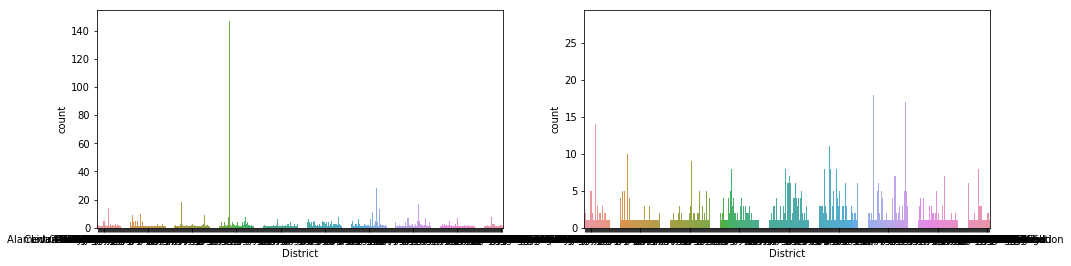

In [482]:
fig, ax = plt.subplots(1,2, figsize = (16,4))
sns.countplot(data = HS_sub, x = 'District', ax = ax[0])
sns.countplot(data = HS_sub[HS_sub.District != 'Los Angeles Unified'], x = 'District', ax = ax[1])


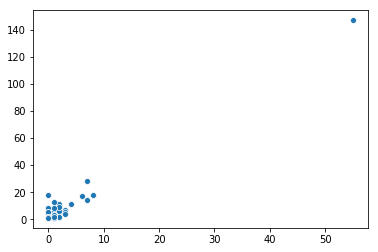

In [373]:
Districts = HS_sub.groupby('District')

num_charters = []
num_schools = []
for dist in Districts:
    num_schools.append(len(dist[1]))
    num_charters.append(sum(dist[1].CharterYN))

sns.scatterplot(x = num_charters, y = num_schools)


In [483]:
HS_sub.District.value_counts().head(10)


Los Angeles Unified        147
San Diego Unified           28
San Francisco Unified       18
Kern High                   18
East Side Union High        17
Oakland Unified             14
Sweetwater Union High       13
Sacramento City Unified     11
Grossmont Union High        11
Fresno Unified              10
Name: District, dtype: int64

In [53]:
for col in testing:
    sb_df_all[col] = pd.to_numeric(sb_df_all[col])

In [80]:
assign_var = ['CharterYN','area1_perc_std_exceed','area3_perc_std_exceed', 'RegularHSGradRate_GF','ELRate_12',  'MetUCCSURate_TA']
assign_numeric = ['area1_perc_std_exceed','area3_perc_std_exceed', 'RegularHSGradRate_GF','ELRate_12',  'MetUCCSURate_TA']
assign_scaled = []
for col in assign_numeric:
    sb_df_all[col] = pd.to_numeric(sb_df_all[col])

assign_df =sb_df_all[assign_var].dropna()

In [81]:
# fix this to not be row-wise...
# this adds variables that are scaled to mean = 0 and unit standard deviation
for col in assign_numeric:
    avg = np.mean(assign_df[col])
    std = np.std(assign_df[col])
    _vec = []
    for ik in range(len(assign_df)):
        try:
            _vec.append((assign_df[col].iloc[ik]-avg)/std)
        except:
            _vec.append(np.nan)
    assign_scaled.append(col+'_ss')
    assign_df[col+'_ss'] = _vec #scaler.transform(assign_df[col])#
    #(assign_df[col]-np.mean(assign_df[col]))/assign_df[col].std
    #assign_numeric.append(col+_ss)
    


In [87]:
means = assign_df[['area1_perc_std_exceed','area3_perc_std_exceed']].mean(axis=0)
stds = assign_df[['area1_perc_std_exceed','area3_perc_std_exceed']].std(axis=0)
assign_df['areas13_perc_std_exceed'] = ((assign_df[['area1_perc_std_exceed','area3_perc_std_exceed']] - means) / stds).mean(axis=1)
assign_scaled.append('areas13_perc_std_exceed')


In [89]:
assign_df['ELRate_12_sqrt']= np.sqrt(assign_df['ELRate_12'].dropna())
assign_scaled.append('ELRate_12_sqrt')

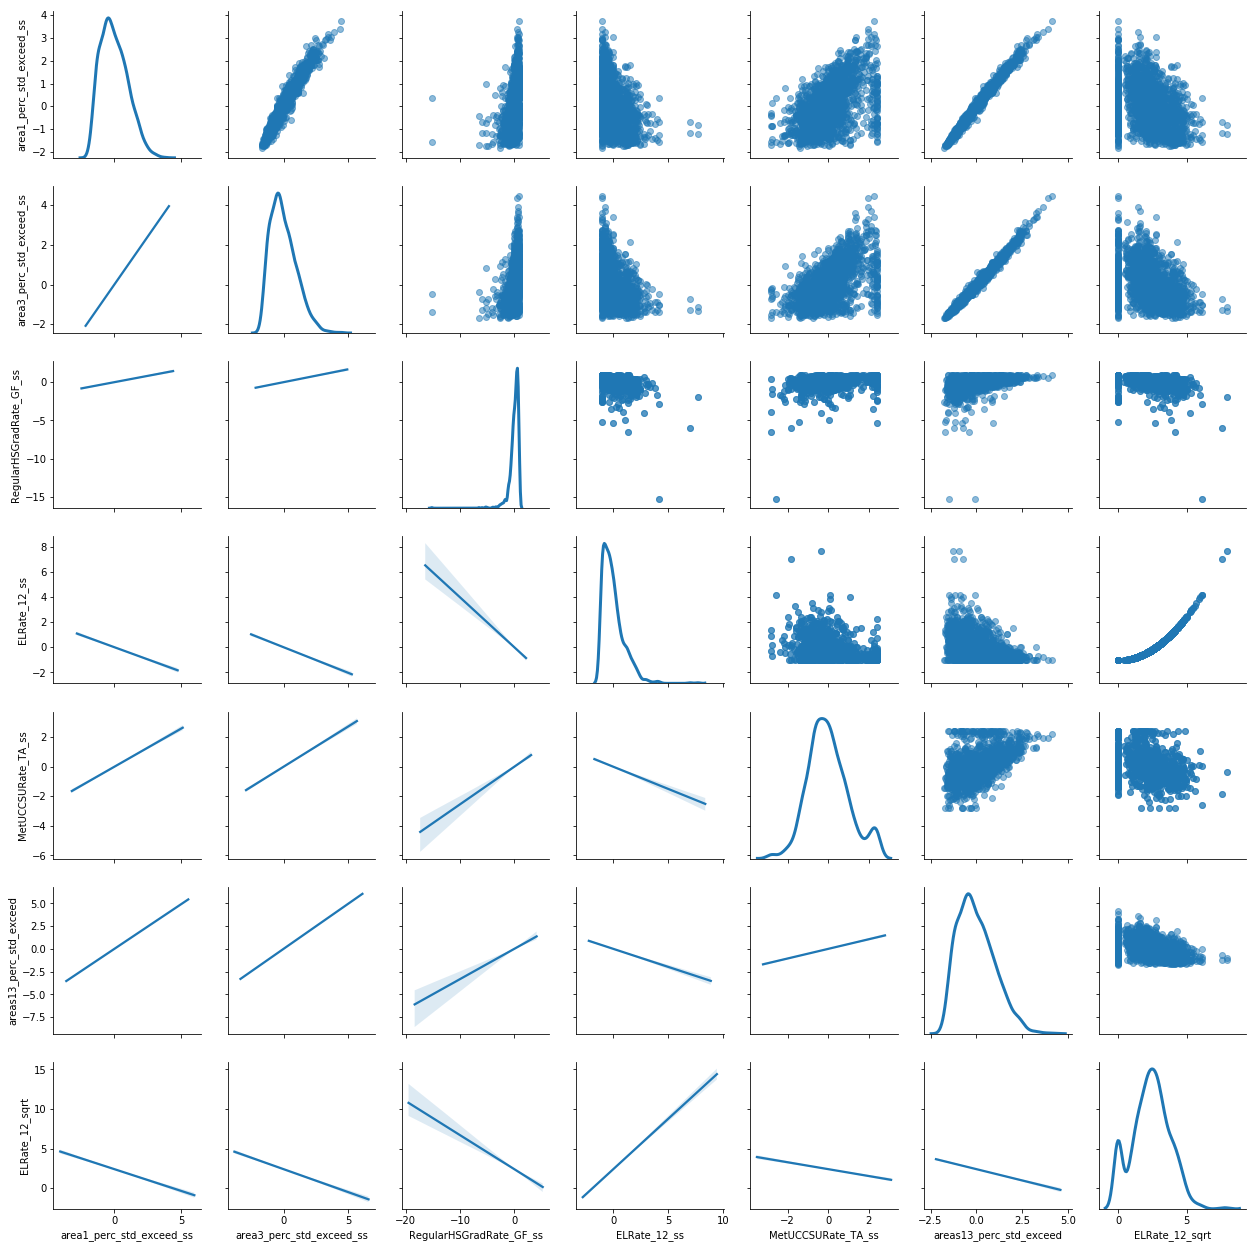

In [90]:
g = sns.PairGrid(assign_df[assign_scaled].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)


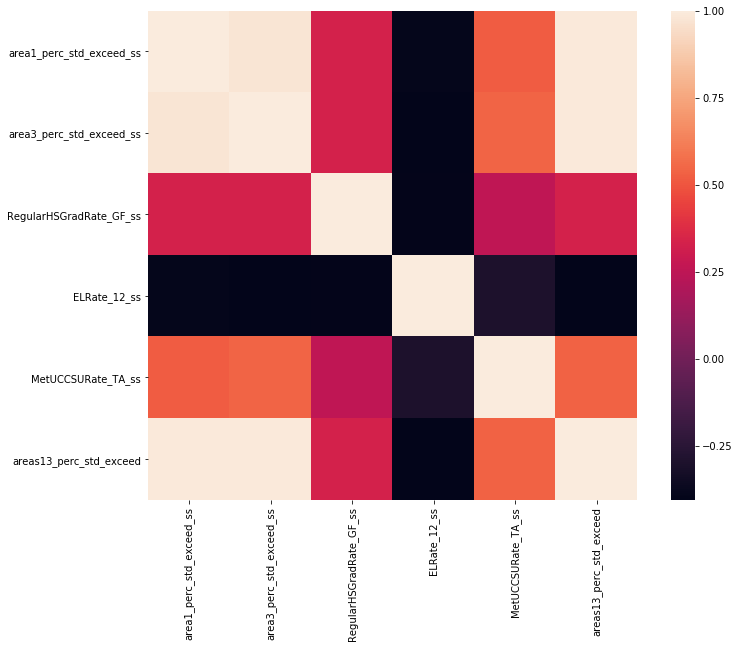

In [88]:
corrmat = assign_df[assign_scaled].dropna().corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True)

In [52]:
testing = ['perc_std_exceed',
       'perc_std_met_exceed', 'area1_perc_std_exceed', 'area2_perc_std_exceed', 'area3_perc_std_exceed',
         'RegularHSGradRate_GF', 'RegularHSGradRate_RB',
         'MetUCCSURate_RA', 'MetUCCSURate_RB',  'ELRate_12',
       'MetUCCSURate_TA']
# 'perc_std_met','RegularHSGradRate_RA',
# 'RegularHSGradRate_GF', 'RegularHSGradRate_GM','RegularHSGradRate_GF', 'RegularHSGradRate_GM',
# 'RegularHSGradRate_RH', 'MetUCCSURate_RH', 'cds','mean_scale_score', 'area4_perc_std_exceed',
# 'area1_perc_std_near','area3_perc_std_near','area2_perc_std_near',  'area4_perc_std_near',


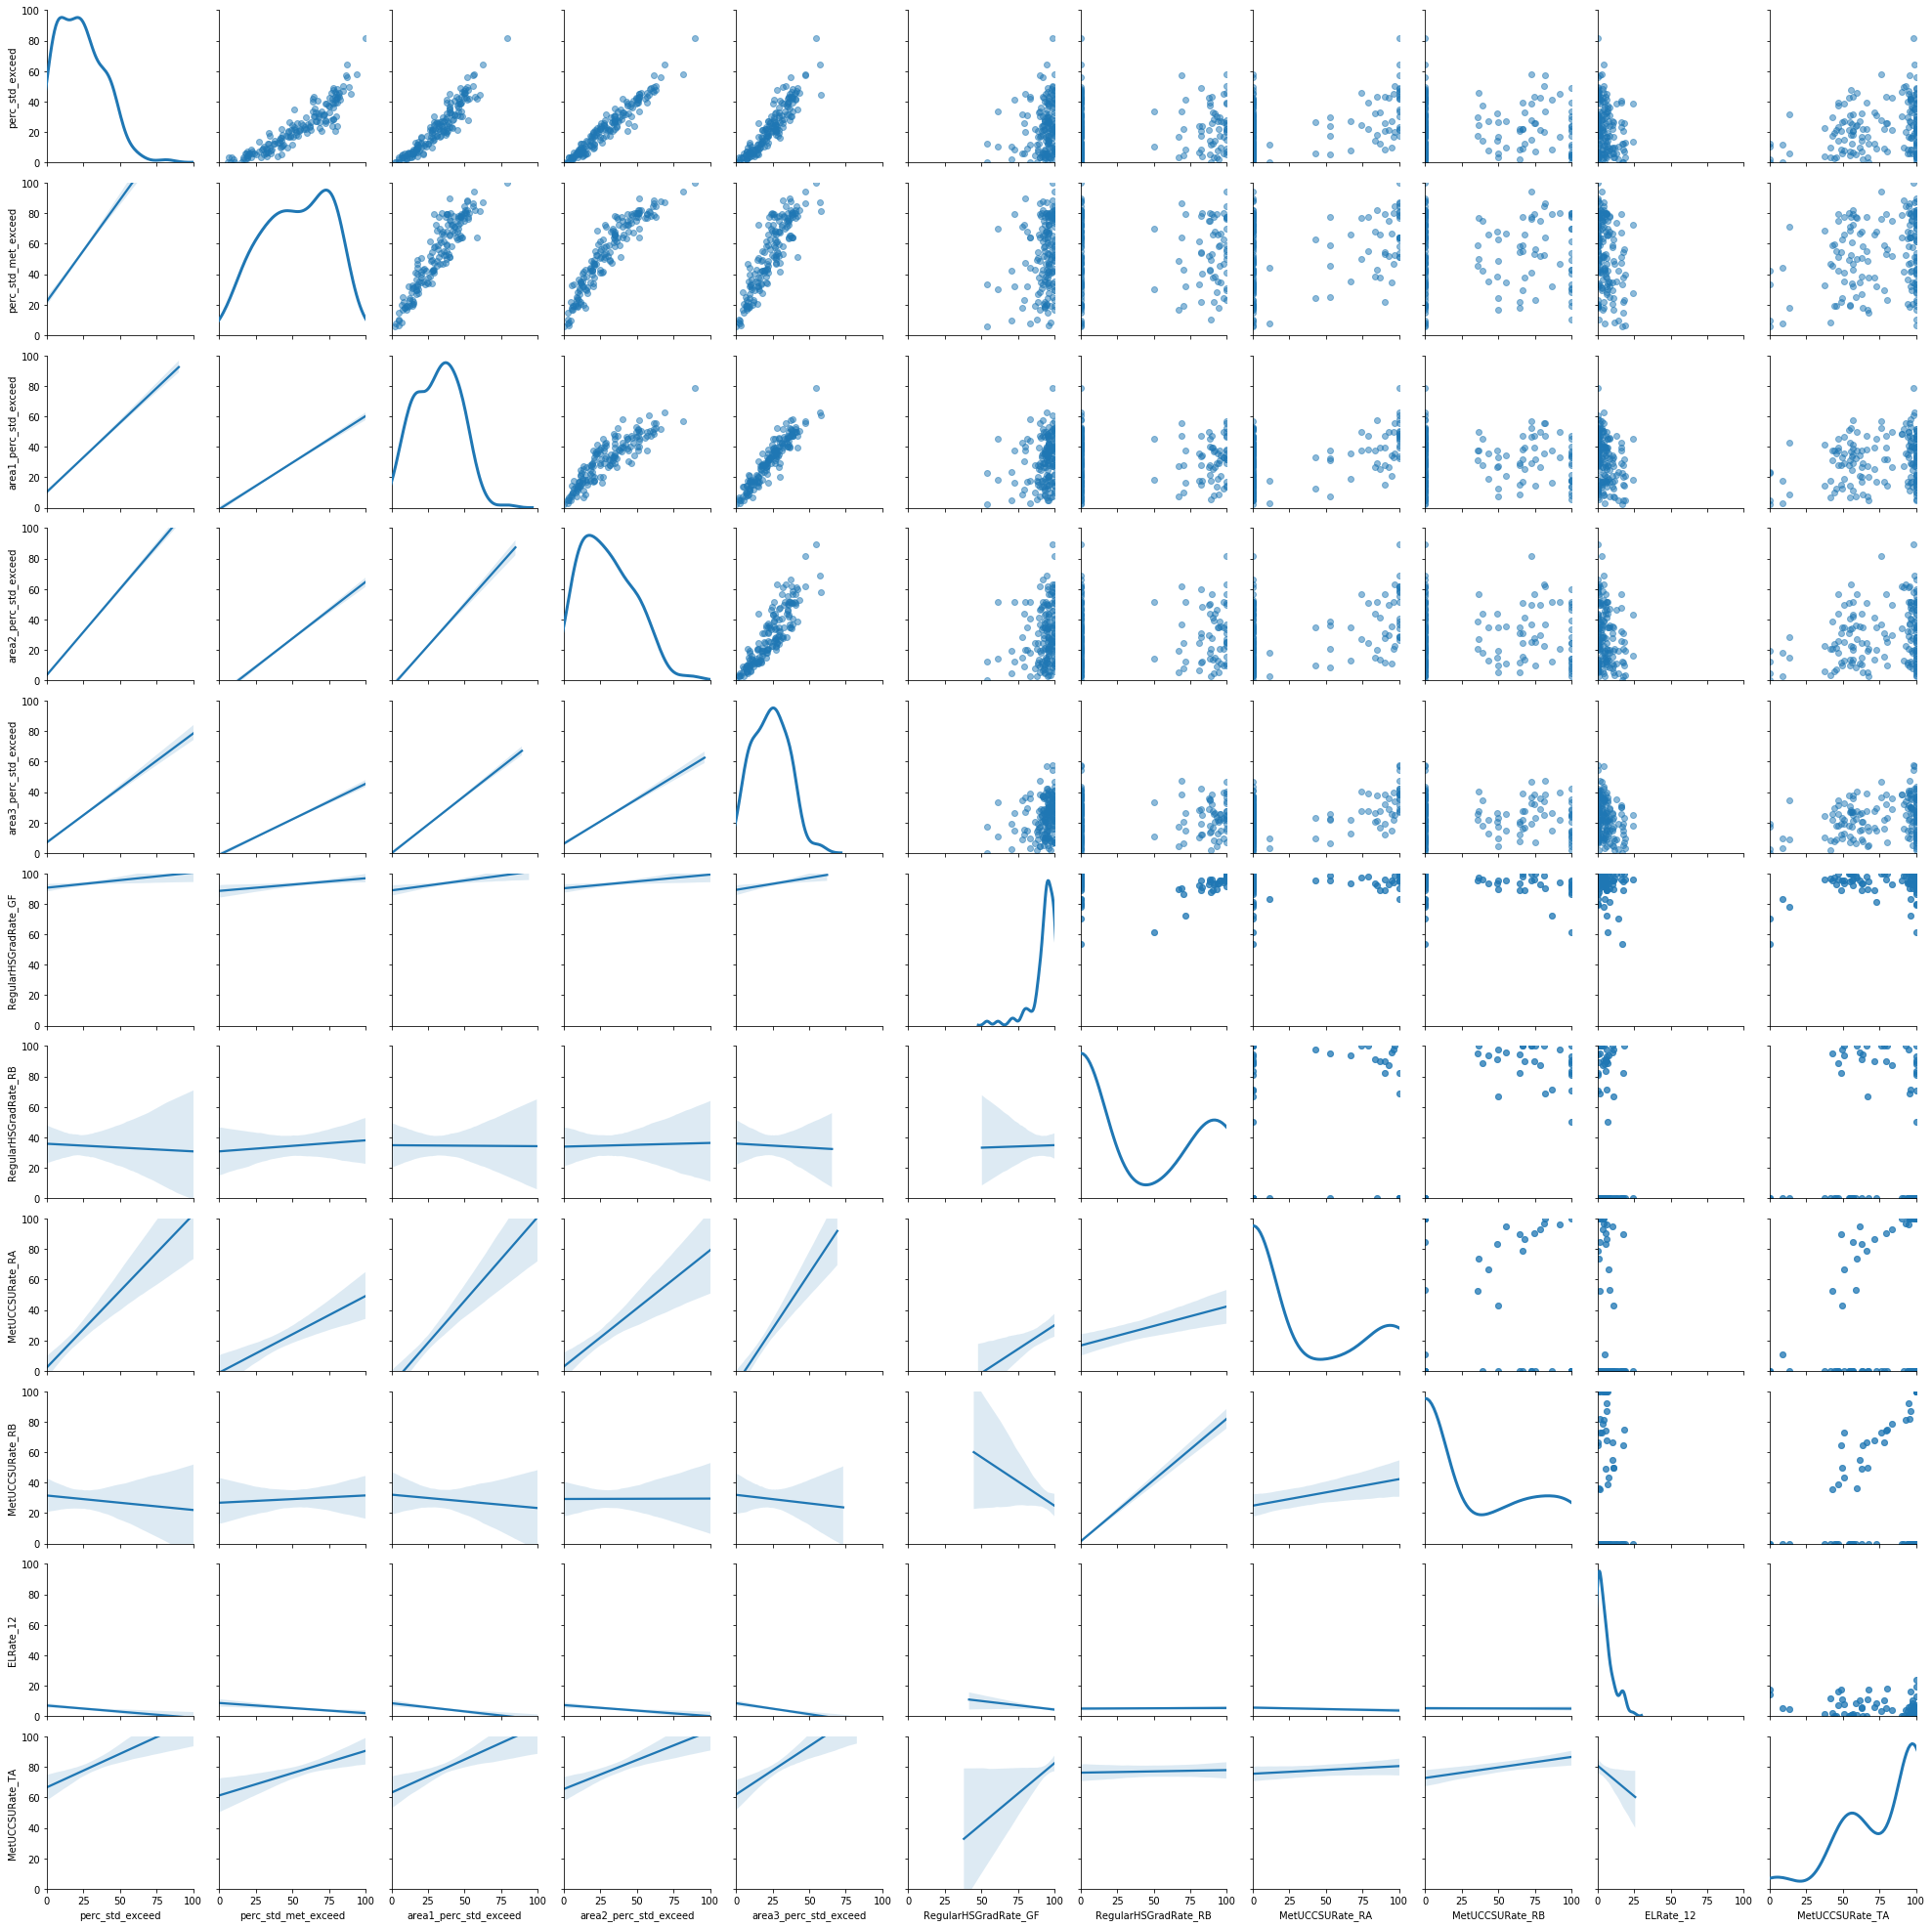

In [54]:
g = sns.PairGrid(sb_df_all[sb_df_all.CharterYN== 1][testing].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)
for ik in range(len(testing)):
    g.axes[ik,0].set_ylim(0,100)
    g.axes[0,ik].set_xlim(0,100)
    
# g.axes[ik-1, 0].set_ylim(0, 2)
# g.axes[0, ik-1].set_xlim(0, 2)

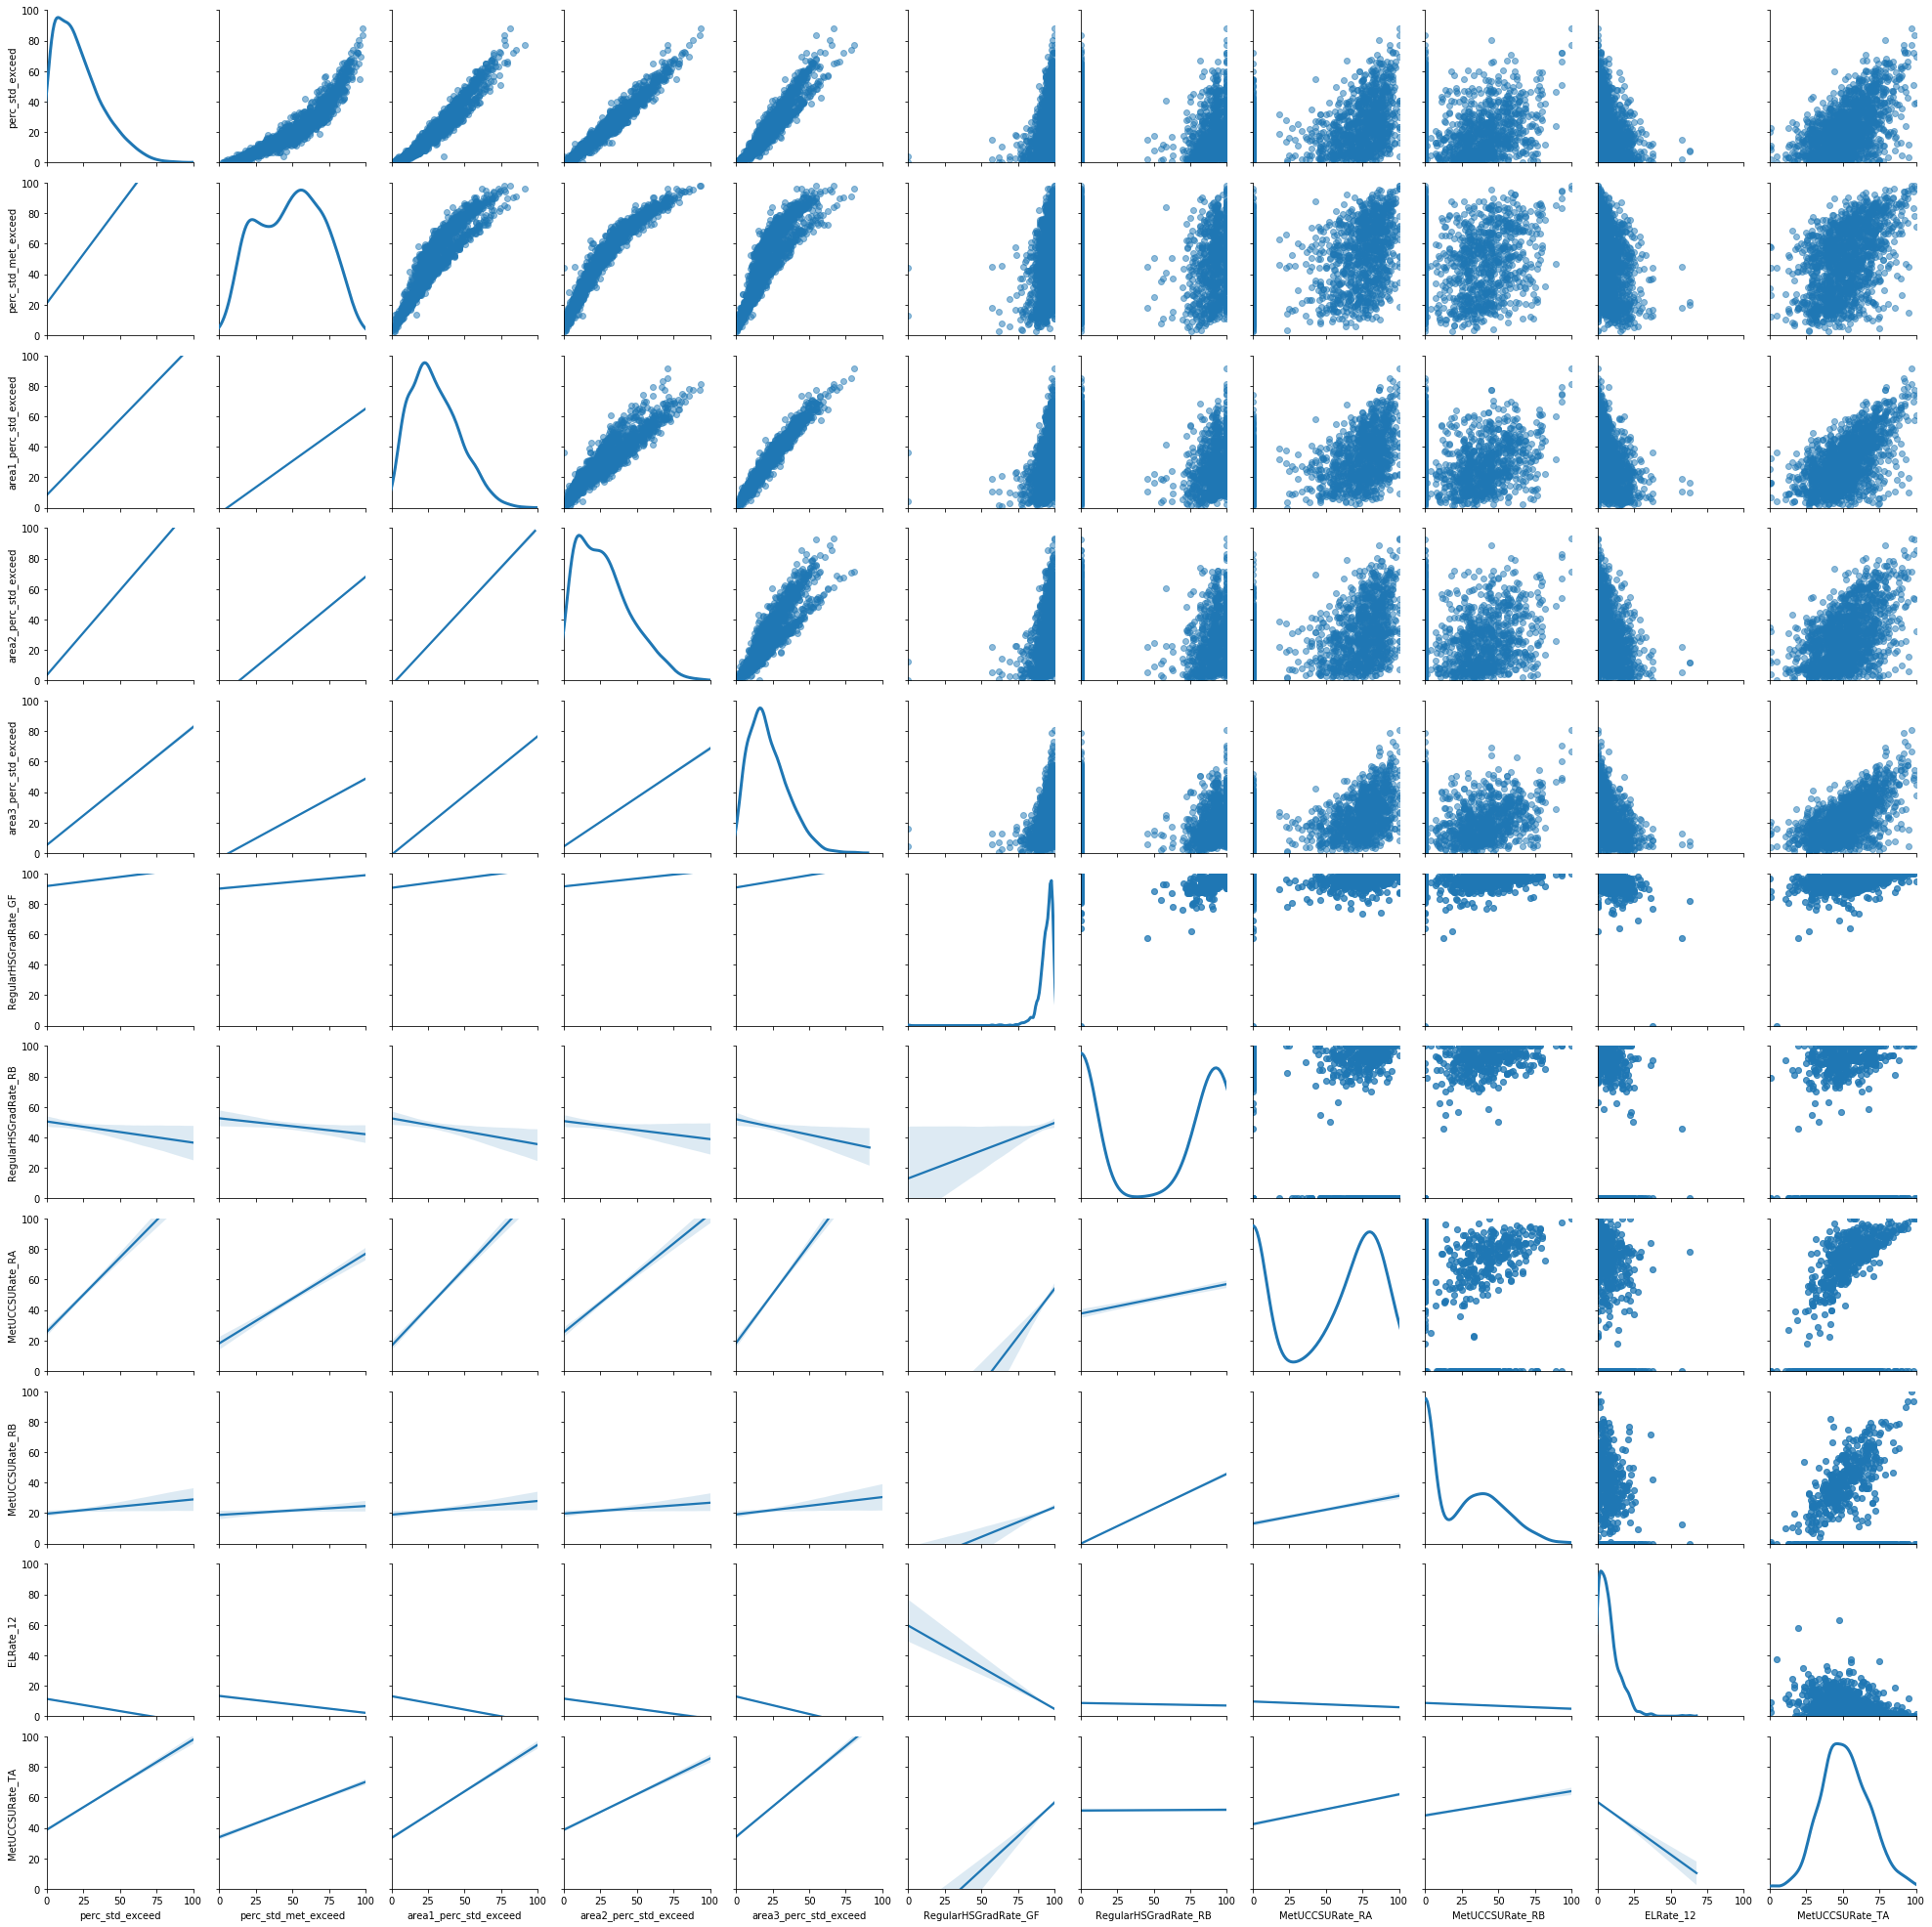

In [55]:
g = sns.PairGrid(sb_df_all[sb_df_all.CharterYN== 0][testing].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)
for ik in range(len(testing)):
    g.axes[ik,0].set_ylim(0,100)
    g.axes[0,ik].set_xlim(0,100)
    
# g.axes[ik-1, 0].set_ylim(0, 2)
# g.axes[0, ik-1].set_xlim(0, 2)

In [166]:
scaler = preprocessing.StandardScaler().fit(sb_df_all[testing])

sb_df_all_scaled = sb_df_all[testing]
sb_df_all_scaled[testing] = scaler.fit_transform(sb_df_all_scaled)# scaler.transform(HS_sub[HS_numeric].dropna())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

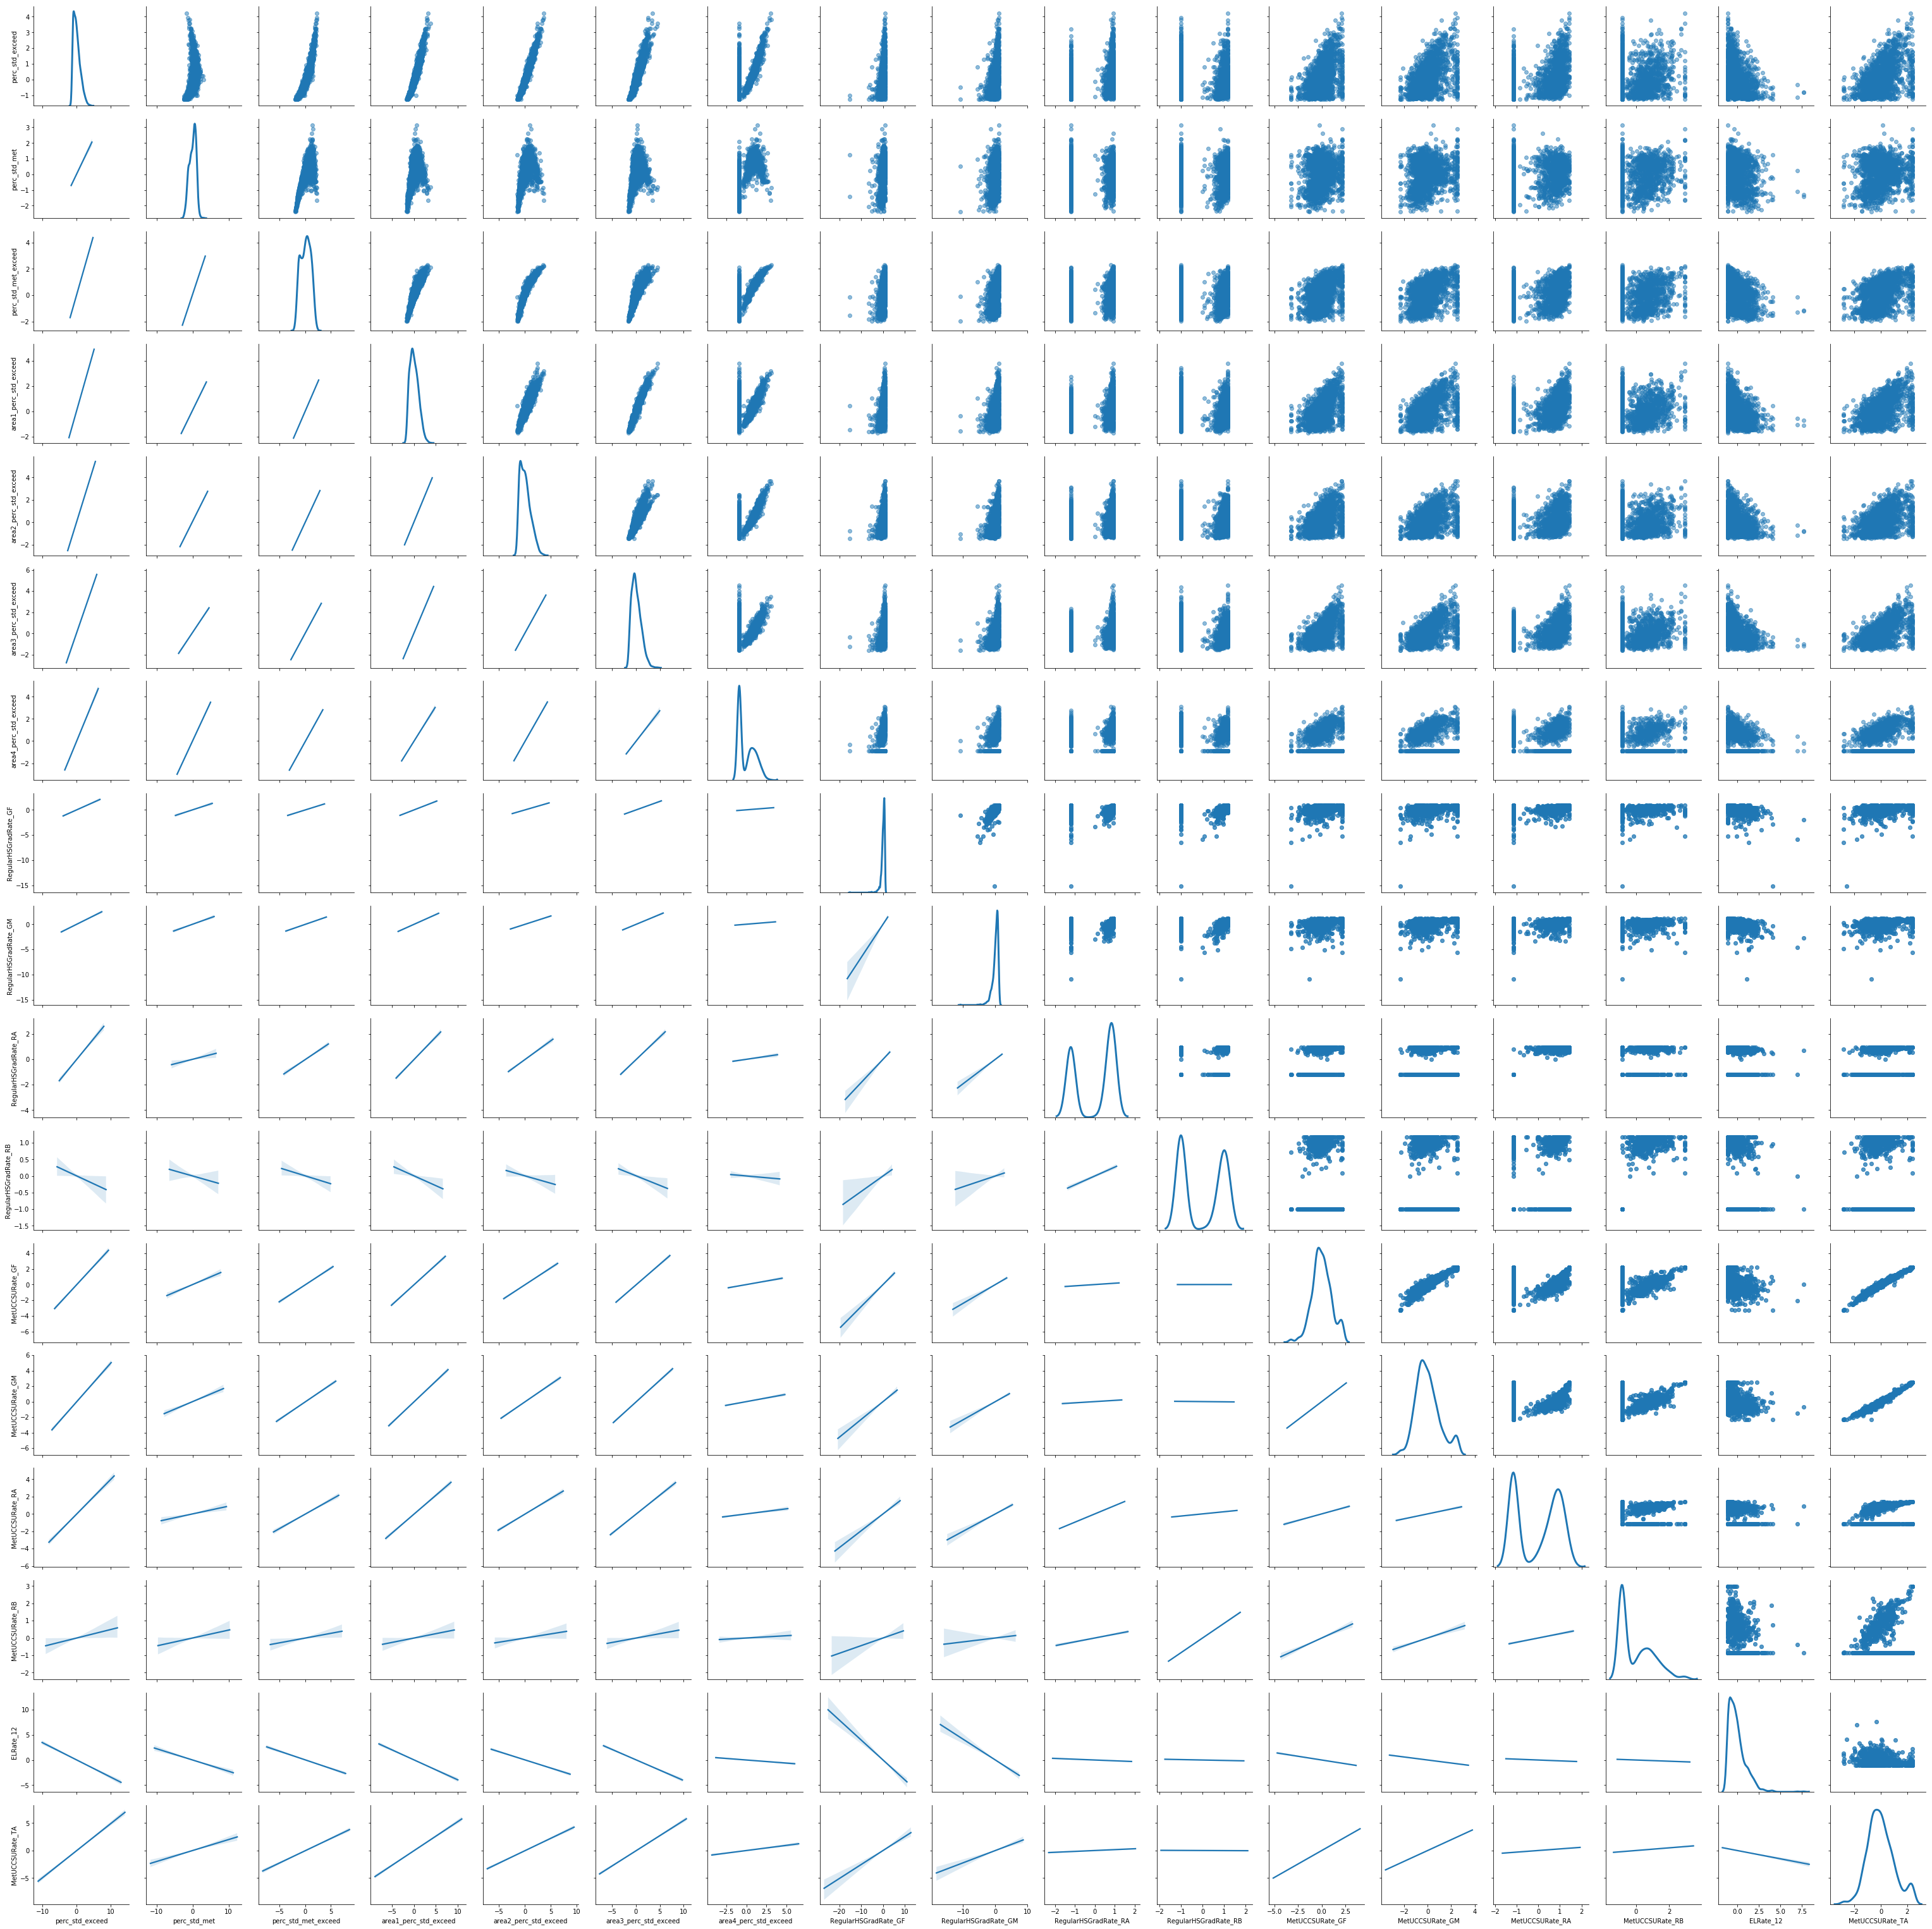

In [167]:
g = sns.PairGrid(sb_df_all_scaled[testing].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)


In [168]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
# scaler = preprocessing.StandardScaler().fit(HS_sub[HS_numeric])
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)

sb_df_all_scaled2 = sb_df_all[testing]
sb_df_all_scaled2[testing] = pt.fit_transform(sb_df_all_scaled2)# scaler.transform(HS_sub[HS_numeric].dropna())


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, v

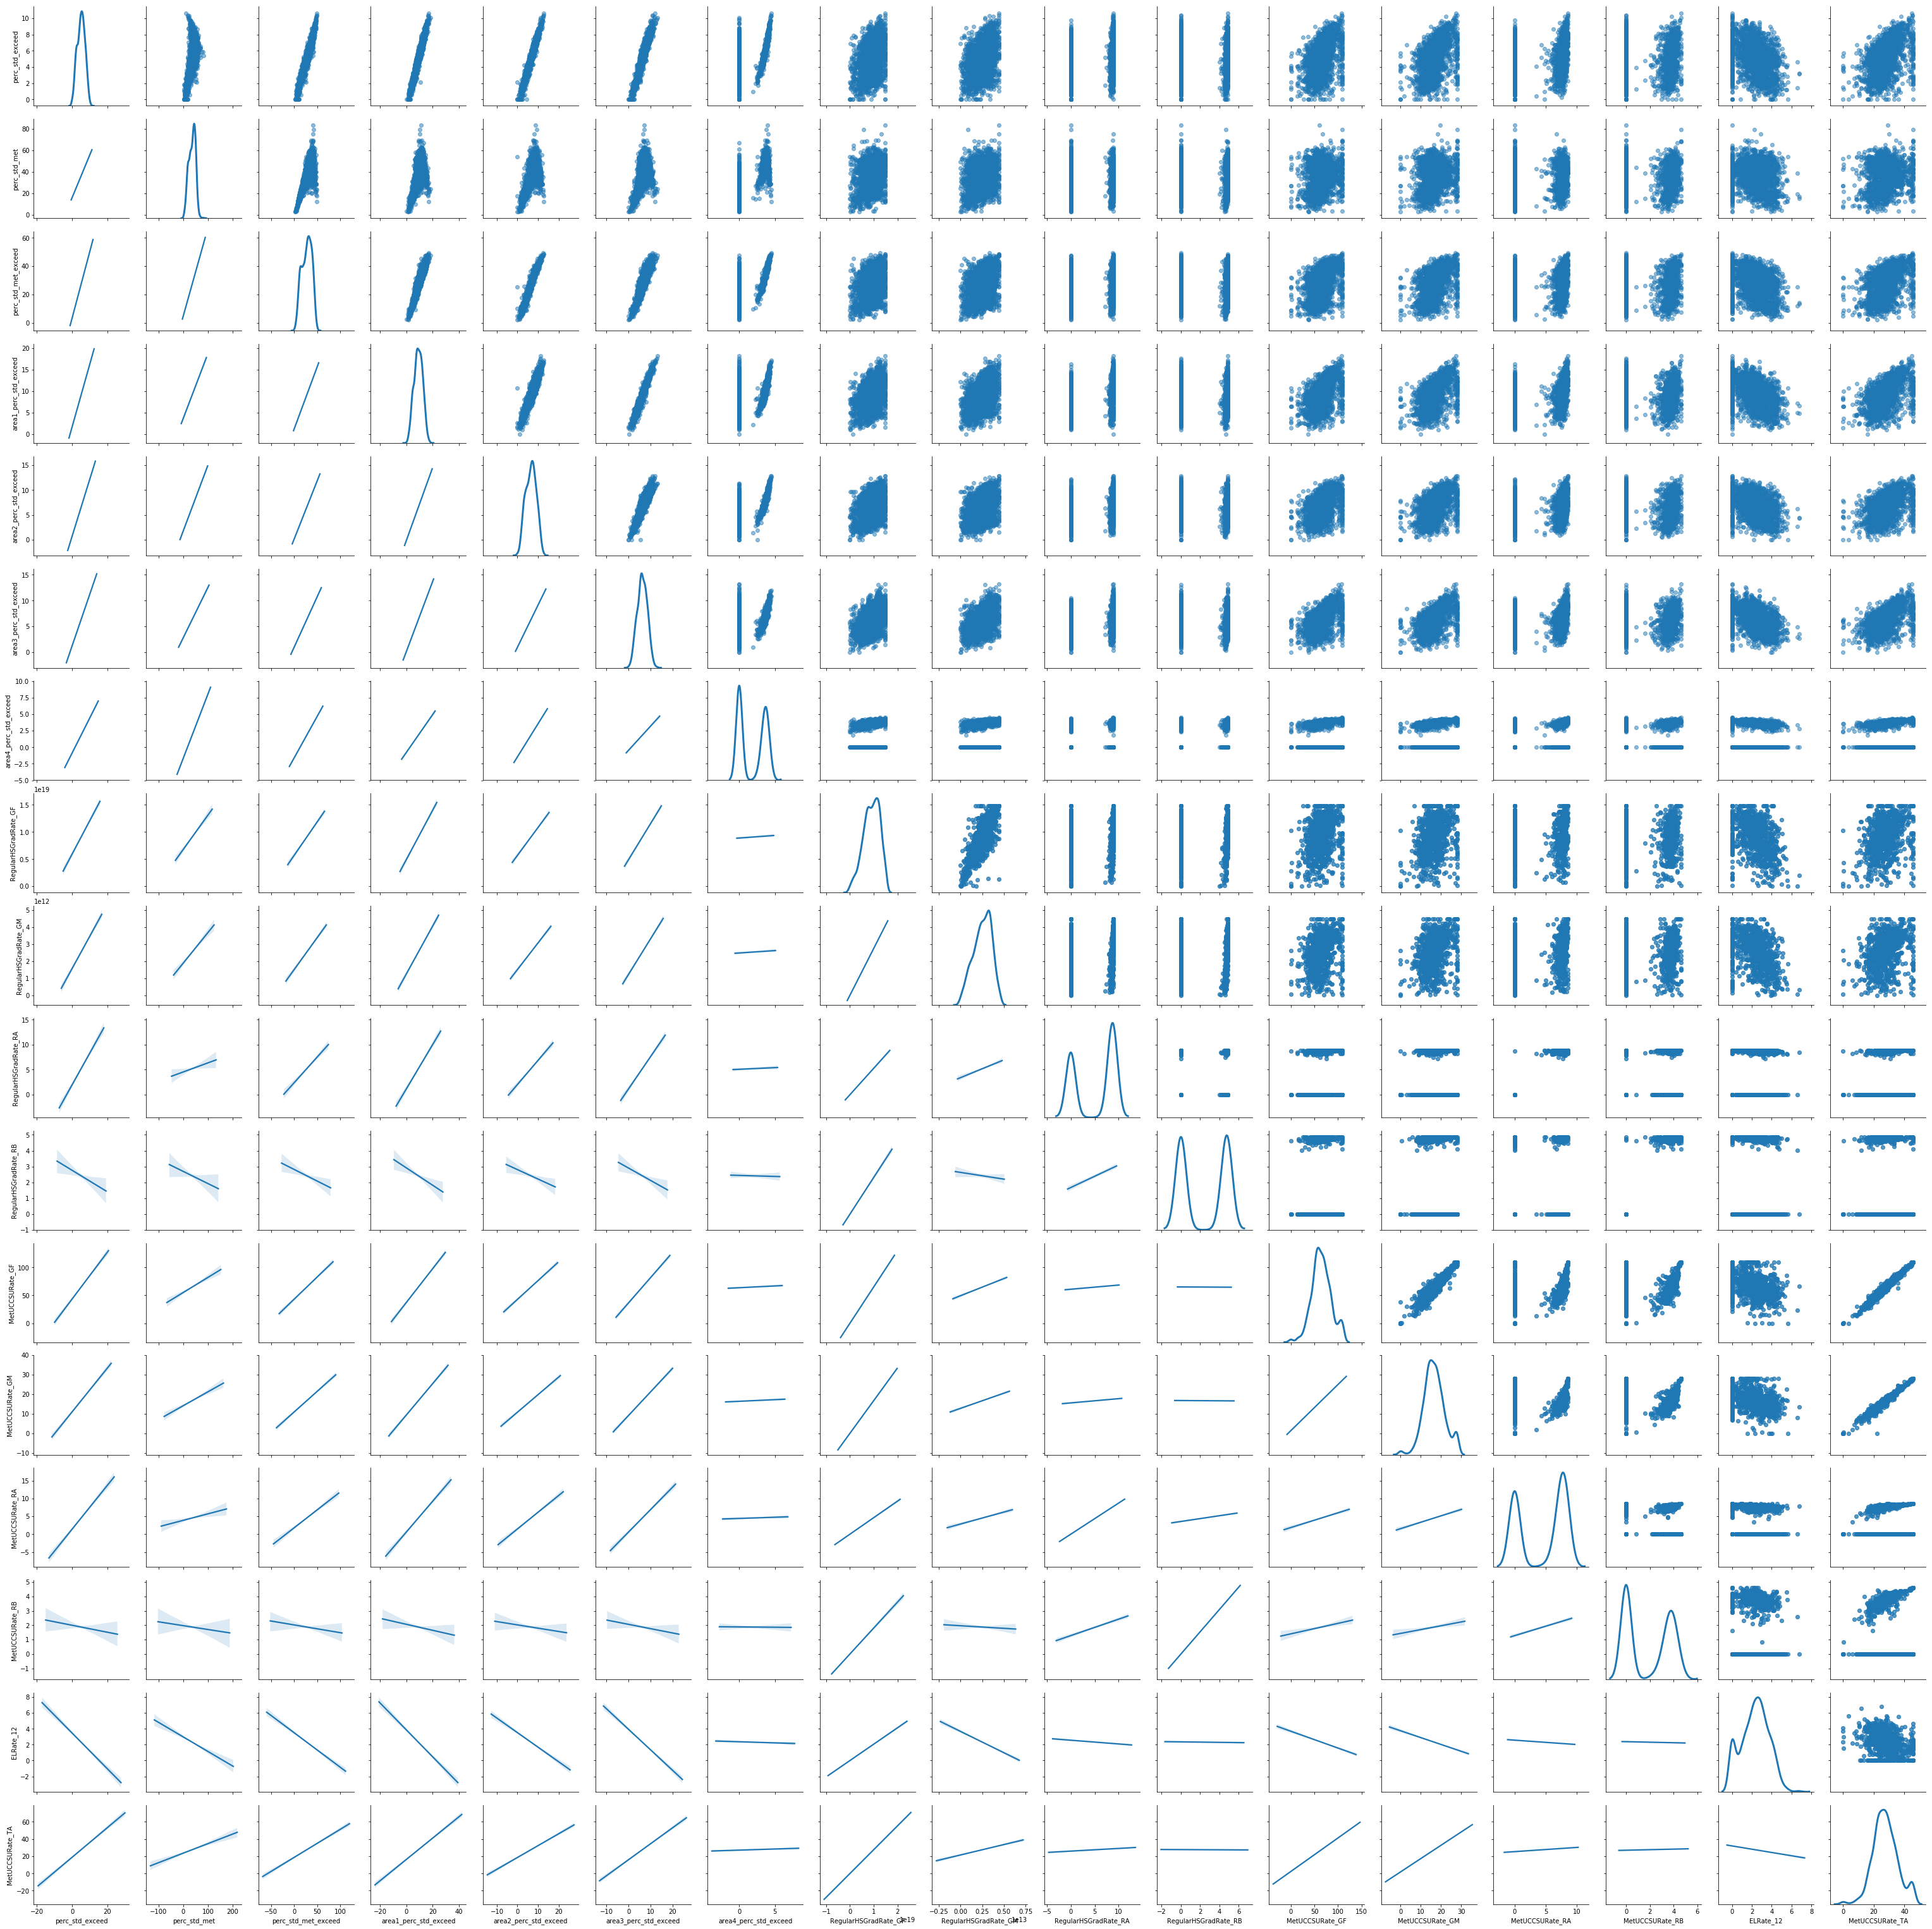

In [169]:
g = sns.PairGrid(sb_df_all_scaled2[testing].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)


In [59]:
HS_numeric = ['RegularHSGradRate_GF', 'RegularHSGradRate_GM','RegularHSGradRate_RH','RegularHSGradRate_RA', 'RegularHSGradRate_RB', 
               'MetUCCSURate_GF', 'MetUCCSURate_GM', 'MetUCCSURate_RH', 'MetUCCSURate_RA', 'MetUCCSURate_RB',
             'ELRate_12', 'MetUCCSURate_TA'] 
HS_numeric = ['RegularHSGradRate_GF', 'RegularHSGradRate_GM','RegularHSGradRate_RA', 'RegularHSGradRate_RB', 
               'MetUCCSURate_GF', 'MetUCCSURate_GM', 'MetUCCSURate_RA', 'MetUCCSURate_RB',
             'ELRate_12', 'CohortStudents_All', 'MetUCCSURate_TA'] 
 
HS_groups = ['CohortStudentsRate_GF', 'CohortStudentsRate_GM','CohortStudentsRate_RA', 'CohortStudentsRate_RB','CohortStudentsRate_RH']

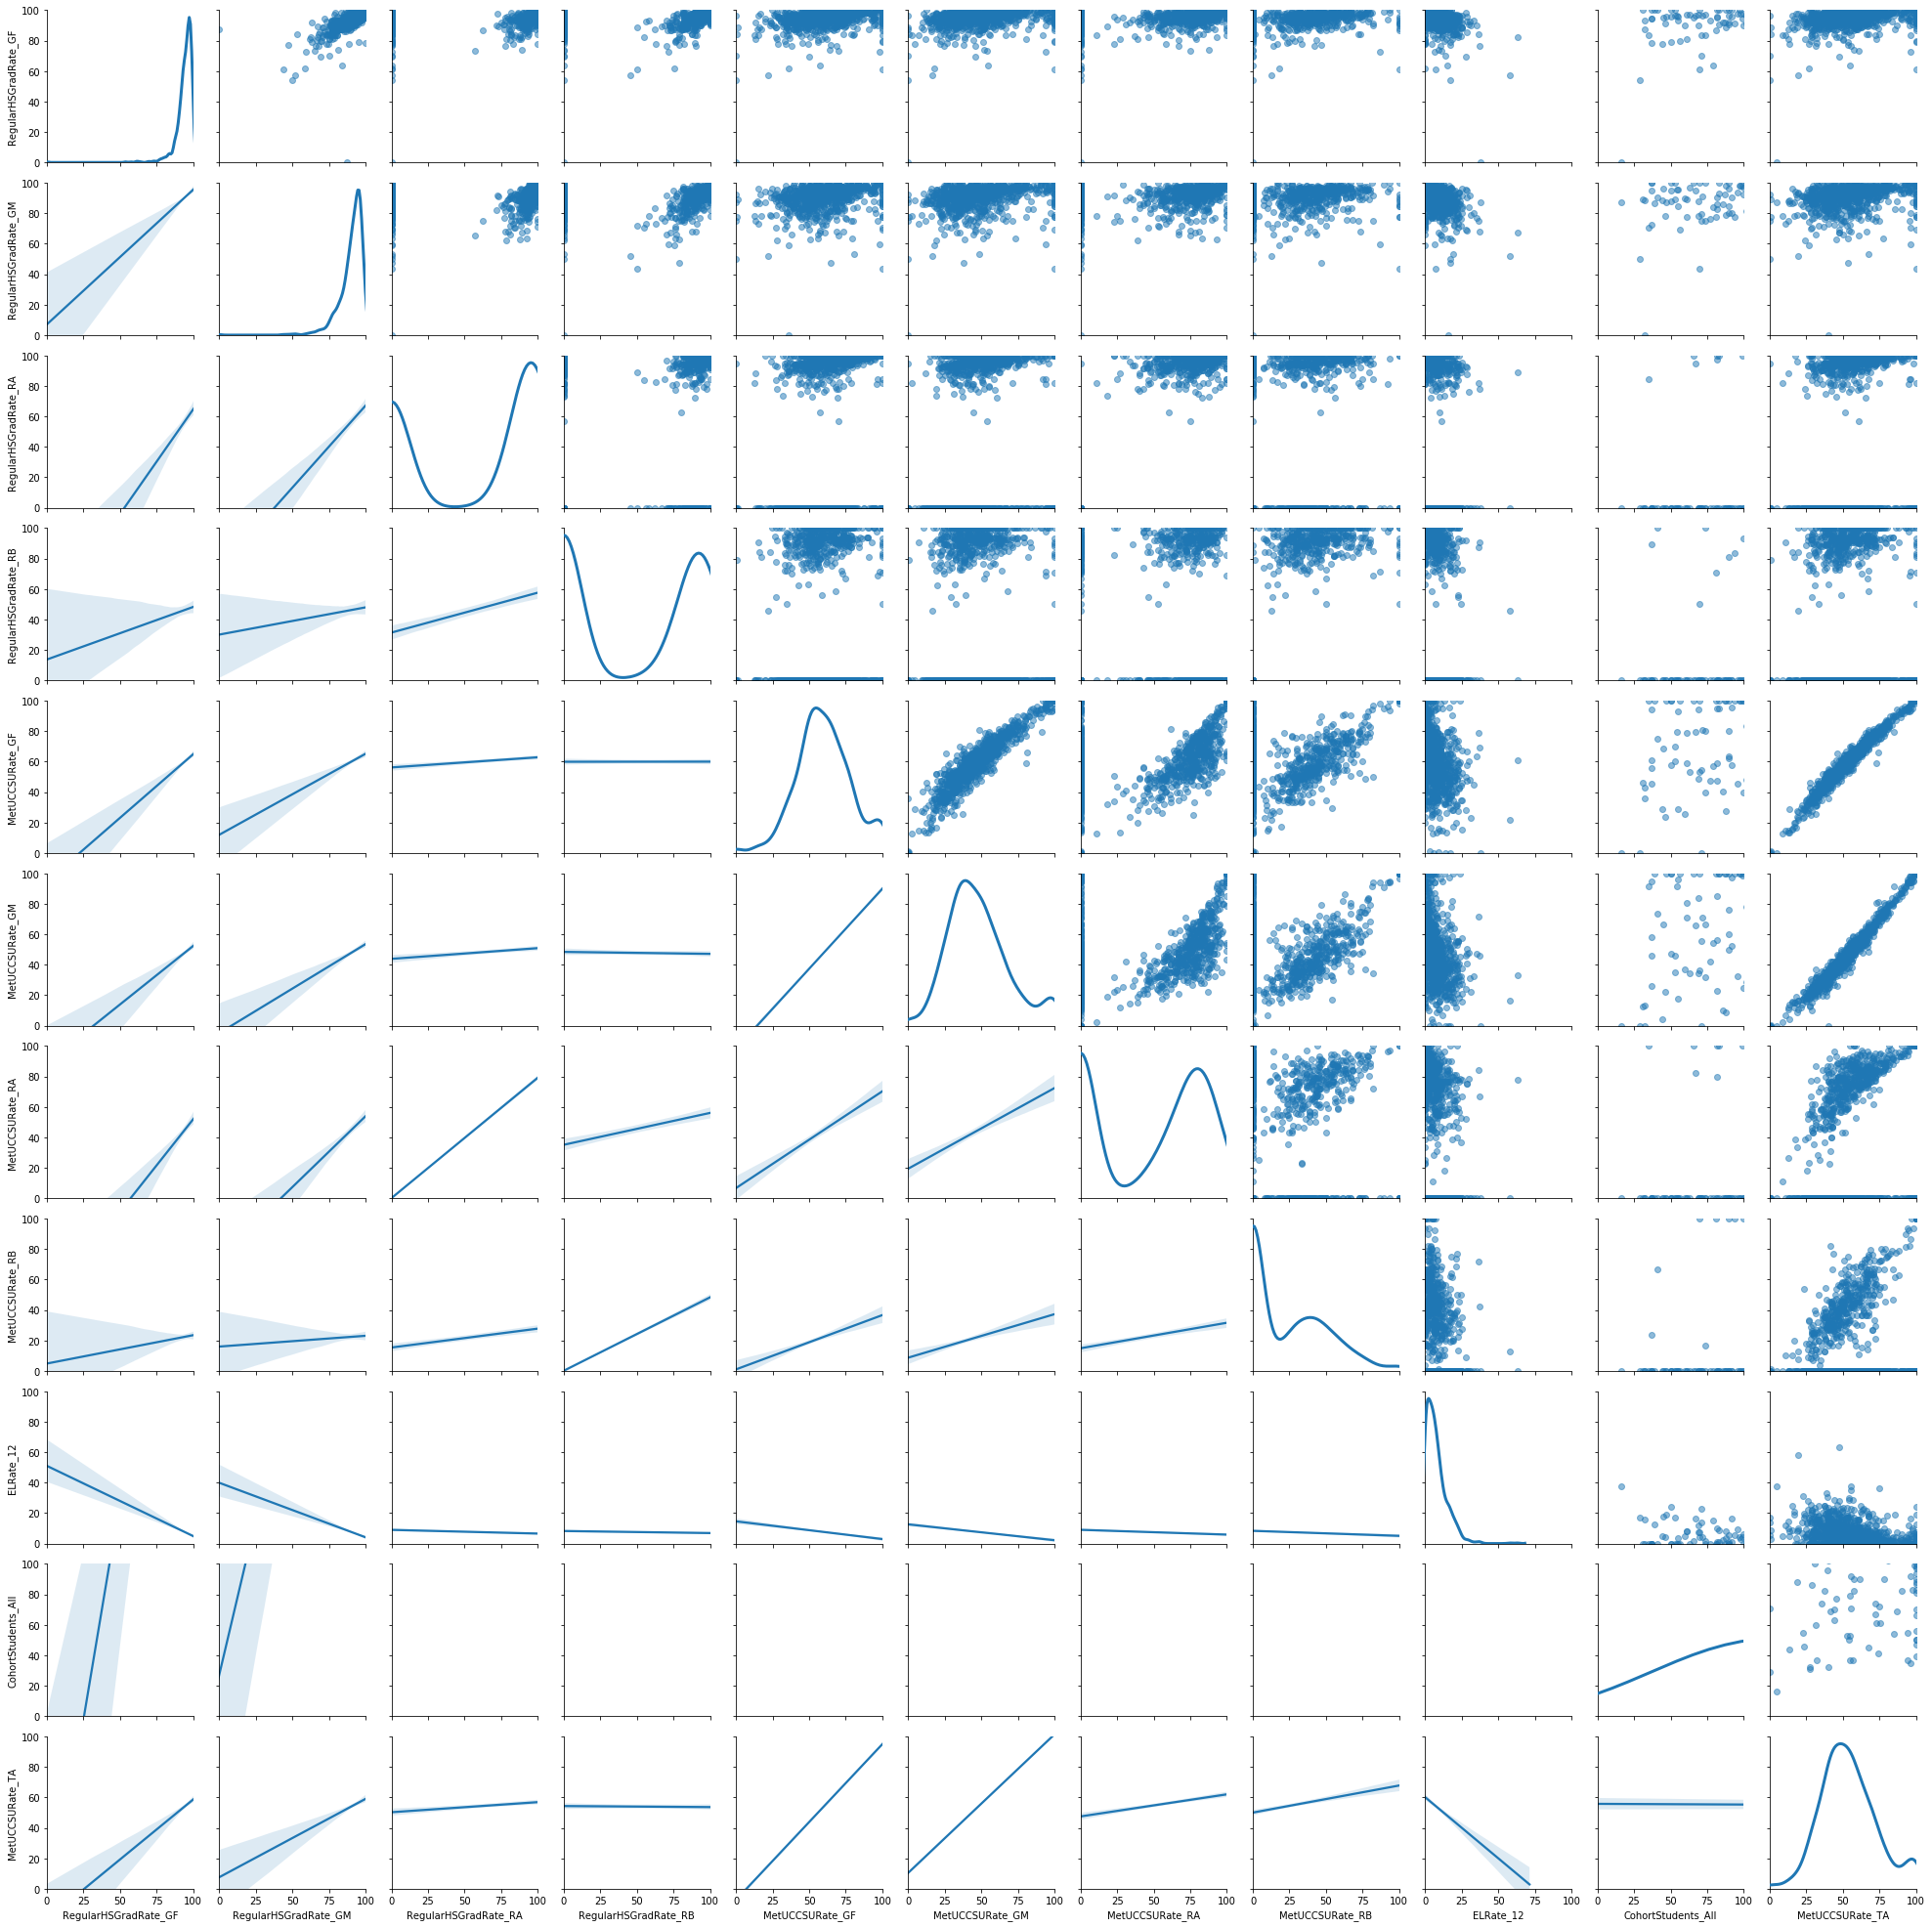

In [60]:
g = sns.PairGrid(HS_sub[HS_numeric].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)
for ik in range(len(HS_numeric)):
    g.axes[ik,0].set_ylim(0,100)
    g.axes[0,ik].set_xlim(0,100)
    
# g.axes[ik-1, 0].set_ylim(0, 2)
# g.axes[0, ik-1].set_xlim(0, 2)

In [61]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
# scaler = preprocessing.StandardScaler().fit(HS_sub[HS_numeric])
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)

HS_scaled2 = HS_sub[HS_numeric]
HS_scaled2[HS_numeric] = pt.fit_transform(HS_scaled2)# scaler.transform(HS_sub[HS_numeric].dropna())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, v

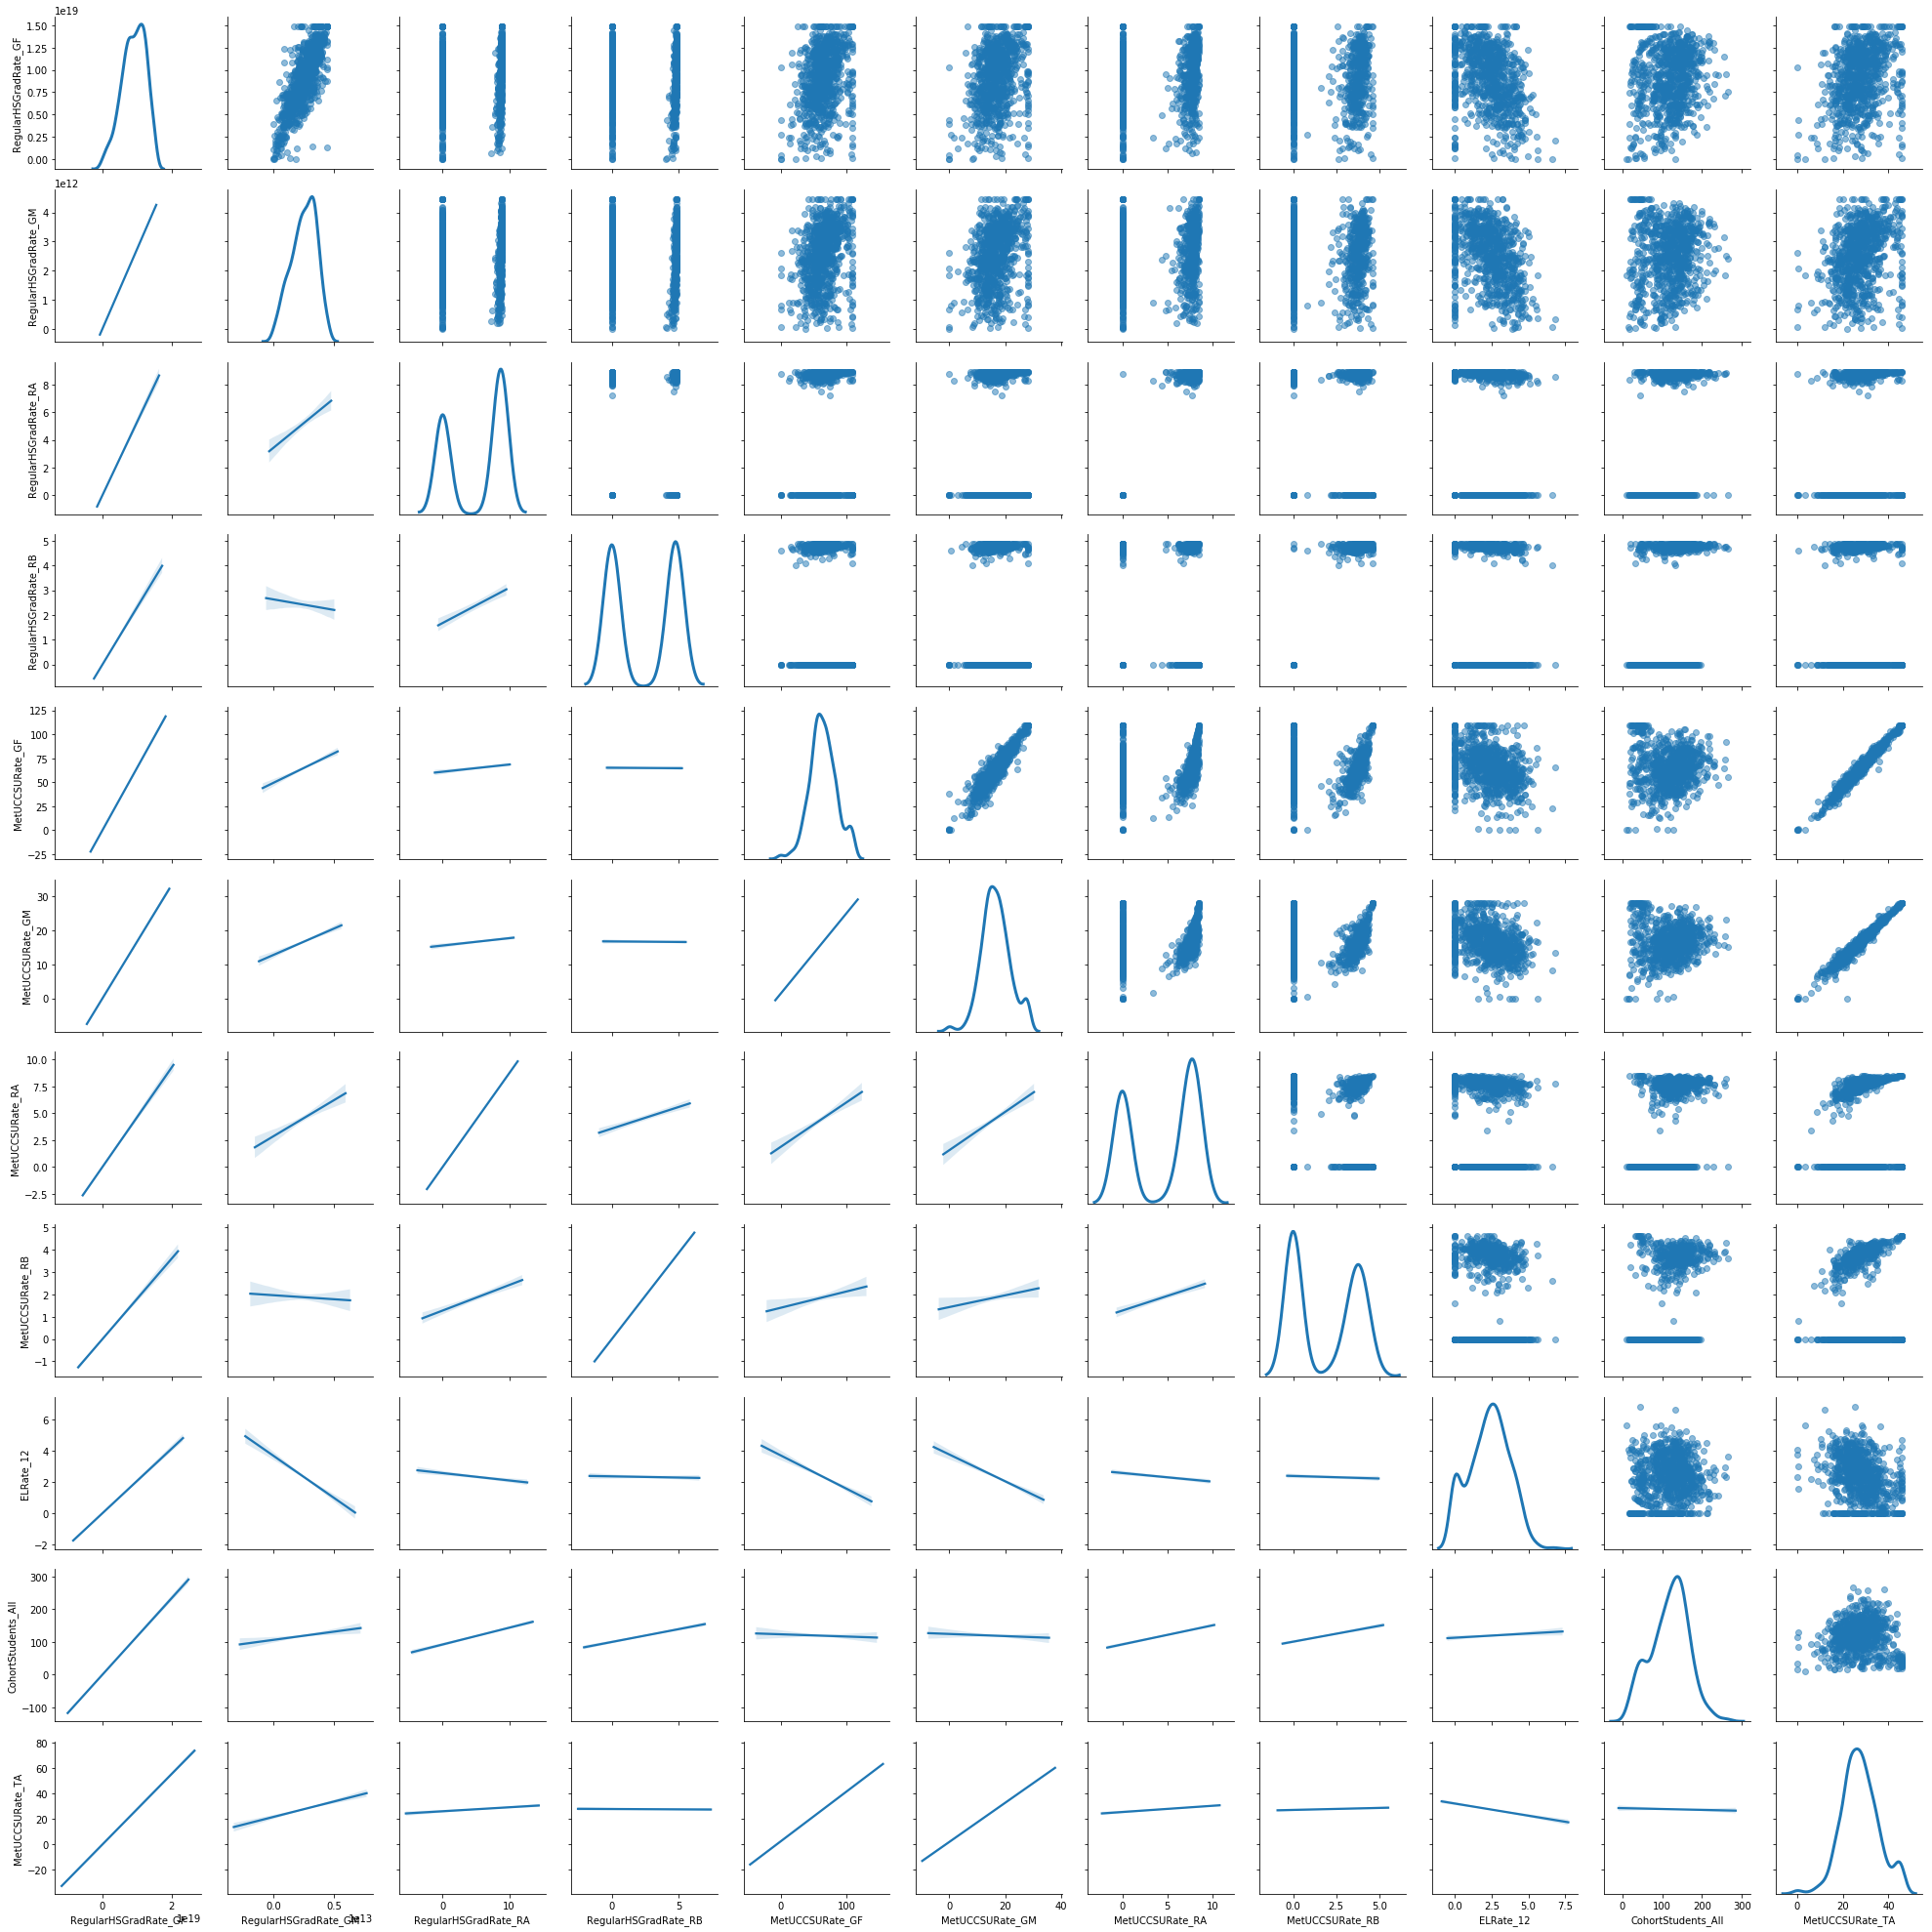

In [62]:
g = sns.PairGrid(HS_scaled2, diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)
# for ik in range(len(HS_numeric)):
#     g.axes[ik,0].set_ylim(0,100)
#     g.axes[0,ik].set_xlim(0,100)
    
# g.axes[ik-1, 0].set_ylim(0, 2)
# g.axes[0, ik-1].set_xlim(0, 2)

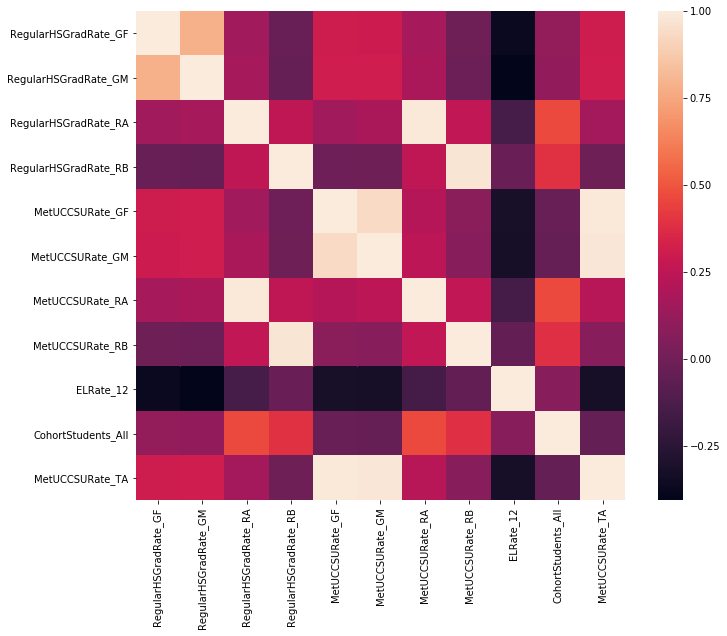

In [63]:
corrmat = HS_scaled2[HS_numeric].dropna().corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True)

In [64]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(HS_sub[HS_numeric])

HS_scaled = HS_sub[HS_numeric]
HS_scaled[HS_numeric] = scaler.transform(HS_sub[HS_numeric].dropna())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, value)


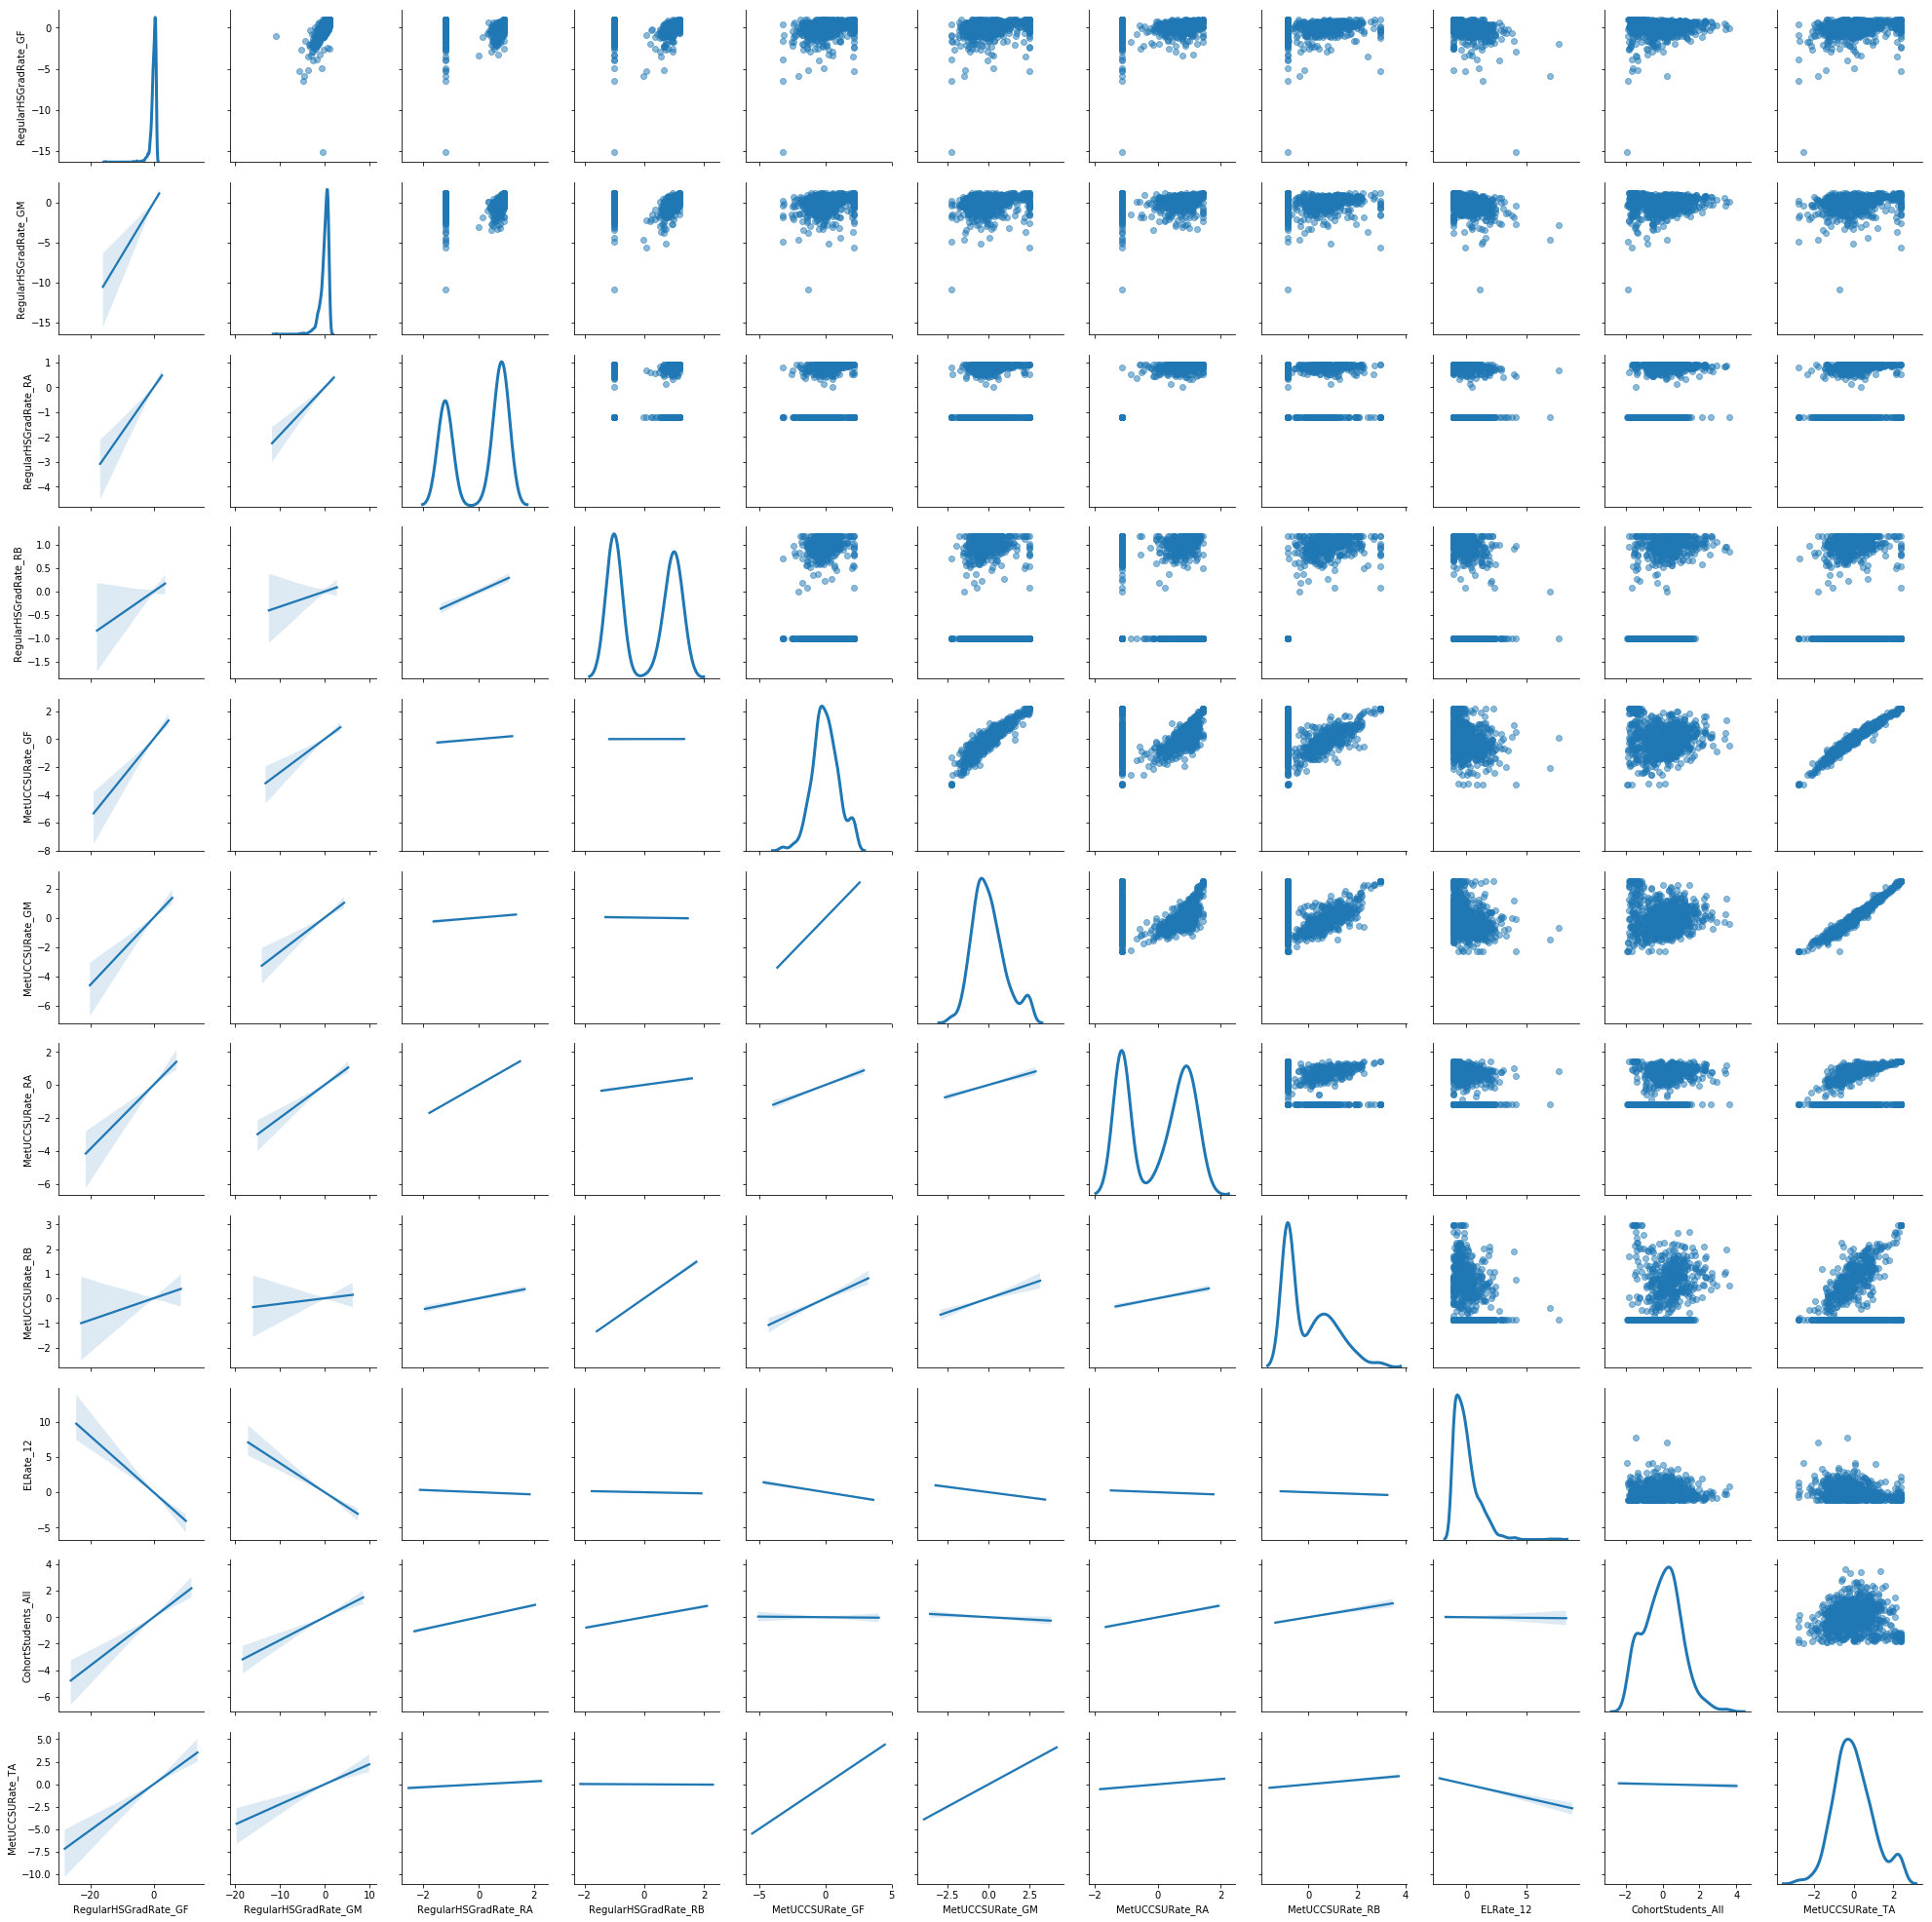

In [65]:
g = sns.PairGrid(HS_scaled, diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)
# for ik in range(len(HS_numeric)):
#     g.axes[ik,0].set_ylim(0,100)
#     g.axes[0,ik].set_xlim(0,100)
    
# g.axes[ik-1, 0].set_ylim(0, 2)
# g.axes[0, ik-1].set_xlim(0, 2)

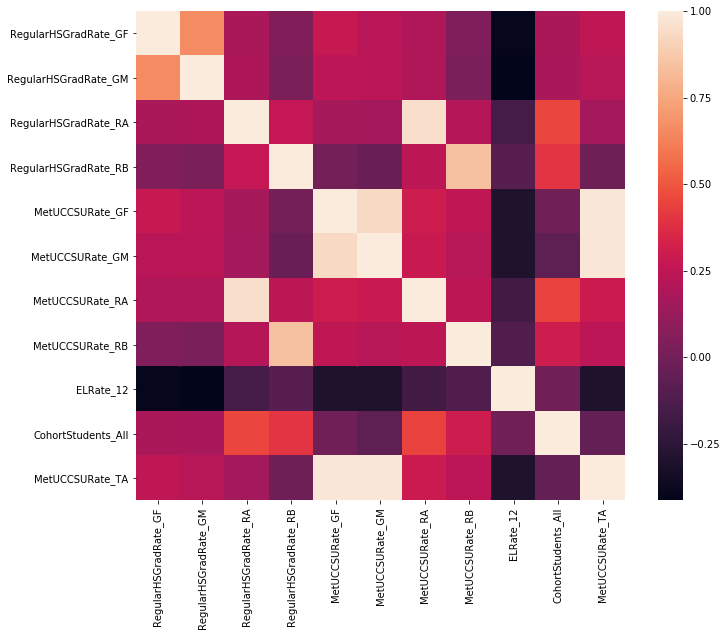

In [66]:
corrmat = HS_sub[HS_numeric].dropna().corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True)

/usr/local/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


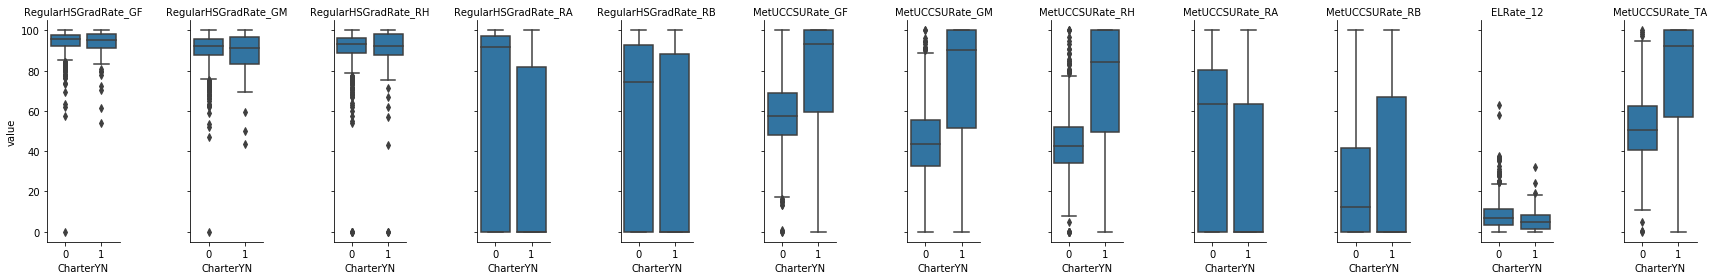

In [592]:
df_long = pd.melt(HS_sub[HS_numeric+['CharterYN']].dropna(),id_vars=['CharterYN'])
g = sns.FacetGrid(df_long, col = 'variable', size = 4, aspect= .5 )
g = g.map(sns.boxplot, "CharterYN", 'value').set_titles("{col_name}")

In [593]:
for col in HS_numeric:
    tval, pval = stats.ttest_ind(HS_sub[HS_sub['CharterYN']== 1][col].dropna(), 
                      HS_sub[HS_sub['CharterYN']== 0][col].dropna())
    print(col, pval)


RegularHSGradRate_GF 0.0518573292406
RegularHSGradRate_GM 0.0324820238685
RegularHSGradRate_RH 0.0214482150555
RegularHSGradRate_RA 5.58468340197e-09
RegularHSGradRate_RB 0.016230728354
MetUCCSURate_GF 2.674518226e-24
MetUCCSURate_GM 3.9387184396e-36
MetUCCSURate_RH 3.48026687924e-40
MetUCCSURate_RA 2.03827956165e-06
MetUCCSURate_RB 0.0113202866905
ELRate_12 0.00480894414084
MetUCCSURate_TA 6.66172937972e-32


In [594]:
# Two binary indicators, one for predominently (over 50%) black high schools and 
# one for predominently hispanic high schools
HS_sub['pred_black'] = [1 if HS_sub['CohortStudentsRate_RB'][ik]>50 else 0 for ik in range(len(HS_sub))]
HS_sub['pred_hisp'] = [1 if HS_sub['CohortStudentsRate_RH'][ik]>50 else 0 for ik in range(len(HS_sub))]

In [595]:
for col in HS_numeric:
    tval, pval = stats.ttest_ind(HS_sub[HS_sub['pred_black']== 1][col].dropna(), 
                      HS_sub[HS_sub['pred_black']== 0][col].dropna())
    print(col, pval)


RegularHSGradRate_GF 0.0114834013329
RegularHSGradRate_GM 0.85332174935
RegularHSGradRate_RH 6.6850329806e-23
RegularHSGradRate_RA 0.0355342411133
RegularHSGradRate_RB 0.100489737561
MetUCCSURate_GF 0.289870519508
MetUCCSURate_GM 0.334444930261
MetUCCSURate_RH 0.0382901951814
MetUCCSURate_RA 0.0450147510841
MetUCCSURate_RB 0.0122336000428
ELRate_12 0.332537009853
MetUCCSURate_TA 0.349747620523


In [566]:
for col in HS_numeric:
    tval, pval = stats.ttest_ind(HS_sub[HS_sub['pred_hisp']== 1][col].dropna(), 
                      HS_sub[HS_sub['pred_hisp']== 0][col].dropna())
    print(col, pval)


RegularHSGradRate_GF 4.71547811954e-07
RegularHSGradRate_GM 1.13757931616e-11
RegularHSGradRate_RH 0.589047099012
RegularHSGradRate_RA 8.27091864482e-22
RegularHSGradRate_RB 0.707332182128
MetUCCSURate_GF 3.35348452956e-08
MetUCCSURate_GM 2.13331343184e-10
MetUCCSURate_RH 0.19548188118
MetUCCSURate_RA 1.91169310405e-22
MetUCCSURate_RB 0.638070780516
ELRate_12 5.30187559805e-36
MetUCCSURate_TA 2.85945941803e-09


In [596]:
# Create a new variable seperating big school districts from small (which is to say Los Angeles from else)
x = []
for dist in HS_sub.groupby('District'):
    if len(dist[1])>30:
        x = x + [1]*len(dist[1])
    else:
        x = x + [0]*len(dist[1])

HS_sub['big_dist'] = x

In [597]:
for col in HS_numeric:
    tval, pval = stats.ttest_ind(HS_sub[HS_sub['big_dist']== 1][col].dropna(), 
                      HS_sub[HS_sub['big_dist']== 0][col].dropna())
    print(col, pval)


RegularHSGradRate_GF 0.0361822197759
RegularHSGradRate_GM 0.0418365771926
RegularHSGradRate_RH 0.0506339882879
RegularHSGradRate_RA 0.0174838073877
RegularHSGradRate_RB 0.000201070912004
MetUCCSURate_GF 0.257903130439
MetUCCSURate_GM 0.253454539312
MetUCCSURate_RH 0.0138422475816
MetUCCSURate_RA 0.00881860886887
MetUCCSURate_RB 0.00265037469199
ELRate_12 0.303088072035
MetUCCSURate_TA 0.230964520486


In [598]:
# Create a new variable seperating big schoool districts from small (which is to say Los Angeles from else)
x = []
for dist in HS_sub.groupby('District'):
    if len(dist[1])<15:
        x = x + [1]*len(dist[1])
    else:
        x = x + [0]*len(dist[1])

HS_sub['small_dist'] = x

In [599]:
for col in HS_numeric:
    tval, pval = stats.ttest_ind(HS_sub[HS_sub['small_dist']== 1][col].dropna(), 
                      HS_sub[HS_sub['small_dist']== 0][col].dropna())
    print(col, pval)


RegularHSGradRate_GF 0.00258394019928
RegularHSGradRate_GM 0.00304731295041
RegularHSGradRate_RH 0.0121155201987
RegularHSGradRate_RA 0.0263182126613
RegularHSGradRate_RB 0.0489098711109
MetUCCSURate_GF 0.421206098824
MetUCCSURate_GM 0.588714260761
MetUCCSURate_RH 0.57879298832
MetUCCSURate_RA 0.0063981946726
MetUCCSURate_RB 0.398191817466
ELRate_12 0.440561776433
MetUCCSURate_TA 0.531680575336


In [600]:
threshold = .2

HS_sub2 = HS_sub.drop(HS_sub.std()[HS_sub.std() < threshold].index.values, axis=1)

In [603]:
HS_sub2.columns

non_numeric = ['CohortStudents_All', 'CohortStudents_GF', 'CohortStudents_GM',
       'CohortStudents_RA', 'CohortStudents_RB', 'CohortStudents_RH', 'District']

In [605]:
HS_sub3 = HS_sub2.drop(non_numeric + ["MetUCCSURate_TA"], axis=1).apply(lambda x: x.corr(HS_sub2.MetUCCSURate_TA)).sort_values(ascending = False)


In [611]:
HS_sub3

MetUCCSURate_GM          0.982501
MetUCCSURate_GF          0.981338
MetUCCSURate_RH          0.852424
CharterYN                0.384954
MetUCCSURate_RA          0.292799
CohortStudentsRate_RA    0.283737
RegularHSGradRate_GF     0.254307
MetUCCSURate_RB          0.242406
RegularHSGradRate_GM     0.223242
RegularHSGradRate_RA     0.160788
CohortStudentsRate_GF    0.105985
RegularHSGradRate_RH     0.082464
CohortStudentsRate_RB   -0.003310
RegularHSGradRate_RB    -0.016301
small_dist              -0.021306
big_dist                -0.040795
CohortStudentsRate_GM   -0.105985
pred_hisp               -0.200304
CohortStudentsRate_RH   -0.224262
ELRate_12               -0.315146
dtype: float64

## GRAVEYARD

1082 1082


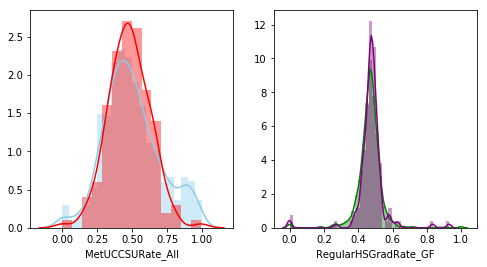

In [470]:
# Create a new variable seperating big schoool districts from small (which is to say Los Angeles from else)
x = []
for dist in HS_sub.groupby('District'):
    if len(dist[1])<30:
        x = x + [1]*len(dist[1])
    else:
        x = x + [0]*len(dist[1])

HS_sub['small_dist'] = x

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
print(len(HS_sub['MetUCCSURate_All'].dropna()), len(HS_sub['MetUCCSURate_All']))
sns.distplot(HS_sub[HS_sub.small_dist == 1]['MetUCCSURate_TA'].dropna(), color= 'skyblue', ax = ax[0])
sns.distplot(HS_sub[HS_sub.small_dist == 0]['MetUCCSURate_TA'].dropna(), color= 'red', ax = ax[0])

sns.distplot(HS_sub[HS_sub.small_dist == 1]['RegularHSGradRate_GF'].dropna(), color= 'green', ax = ax[1])
sns.distplot(HS_sub[HS_sub.small_dist == 0]['RegularHSGradRate_GF'].dropna(), color= 'purple', ax = ax[1])
# There is no number that demonstrates that school district size has an appreciable effect
# on UC/CSU eligibility

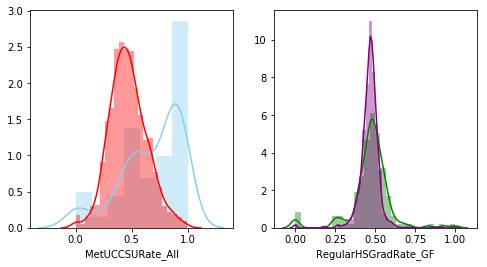

In [471]:
# print(len(HS_sub['MetUCCSURate_All'].dropna()), len(HS_sub['MetUCCSURate_All']))
# sns.distplot(HS_sub[HS_sub.CharterYN == 1]['MetUCCSURate_All'].dropna(), color= 'skyblue')
# sns.distplot(HS_sub[HS_sub.CharterYN == 0]['MetUCCSURate_All'].dropna(), color= 'red')

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
# print(len(HS_sub['MetUCCSURate_All'].dropna()), len(HS_sub['MetUCCSURate_All']))
sns.distplot(HS_sub[HS_sub.CharterYN == 1]['MetUCCSURate_All'].dropna(), color= 'skyblue', ax = ax[0])
sns.distplot(HS_sub[HS_sub.CharterYN == 0]['MetUCCSURate_All'].dropna(), color= 'red', ax = ax[0])

sns.distplot(HS_sub[HS_sub.CharterYN == 1]['RegularHSGradRate_GF'].dropna(), color= 'green', ax = ax[1])
sns.distplot(HS_sub[HS_sub.CharterYN == 0]['RegularHSGradRate_GF'].dropna(), color= 'purple', ax = ax[1])
# There is no number that demonstrates that school district size has an appreciable effect
# on UC/CSU eligibility

1082 1082


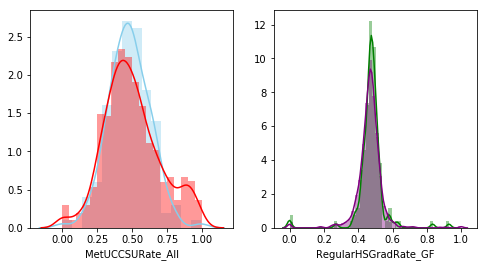

In [472]:
# Create a new variable seperating big schoool districts from small (which is to say Los Angeles from else)
x = []
for dist in HS_sub.groupby('District'):
    if len(dist[1])>30:
        x = x + [1]*len(dist[1])
    else:
         x = x + [0]*len(dist[1])

HS_sub['big_dist'] = x

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
print(len(HS_sub['MetUCCSURate_All'].dropna()), len(HS_sub['MetUCCSURate_All']))
sns.distplot(HS_sub[HS_sub.big_dist == 1]['MetUCCSURate_All'].dropna(), color= 'skyblue', ax = ax[0])
sns.distplot(HS_sub[HS_sub.big_dist == 0]['MetUCCSURate_All'].dropna(), color= 'red', ax = ax[0])

sns.distplot(HS_sub[HS_sub.big_dist == 1]['RegularHSGradRate_GF'].dropna(), color= 'green', ax = ax[1])
sns.distplot(HS_sub[HS_sub.big_dist == 0]['RegularHSGradRate_GF'].dropna(), color= 'purple', ax = ax[1])
# There is no number that demonstrates that school district size has an appreciable effect
# on UC/CSU eligibility

In [473]:
HS_sub[['CharterYN',
       'MetUCCSURate_RH', 'RegularHSGradRate_GF', 'MetUCCSURate_All',
       'small_dist', 'EL_GR12_rate']].describe()

CharterYN  MetUCCSURate_RH  RegularHSGradRate_GF  MetUCCSURate_All  \
count  1082.000000      1082.000000           1082.000000       1082.000000   
mean      0.131238         0.234009              0.467025          0.496707   
std       0.337817         0.188575              0.076567          0.196696   
min       0.000000         0.000000              0.000000          0.000000   
25%       0.000000         0.094427              0.440808          0.366973   
50%       0.000000         0.188435              0.470588          0.474827   
75%       0.000000         0.315079              0.497877          0.612209   
max       1.000000         0.980769              1.000000          1.000000   

        small_dist  EL_GR12_rate  
count  1082.000000   1082.000000  
mean      0.869686      0.087434  
std       0.336805      0.077978  
min       0.000000      0.000000  
25%       1.000000      0.029908  
50%       1.000000      0.067024  
75%       1.000000      0.124358  
max       1.000000      0.629630

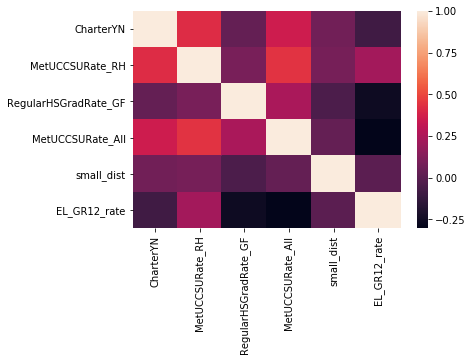

In [474]:
corr = HS_sub[['CharterYN',
       'MetUCCSURate_RH', 'RegularHSGradRate_GF', 'MetUCCSURate_All',
       'small_dist', 'EL_GR12_rate']].corr()
sns.heatmap(corr)

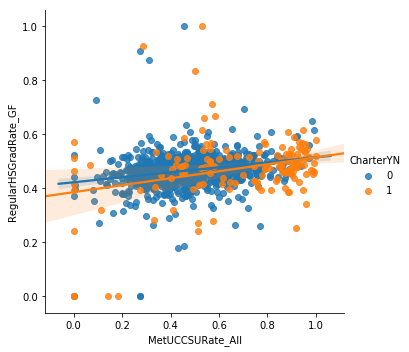

In [452]:
sns.lmplot(data = HS_sub, x = 'MetUCCSURate_All', y = 'RegularHSGradRate_GF', hue = 'CharterYN')


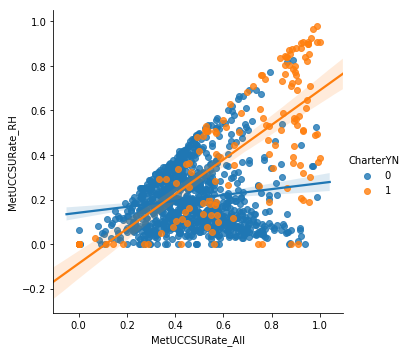

In [453]:
sns.lmplot(data = HS_sub, x = 'MetUCCSURate_All', y = 'MetUCCSURate_RH', hue = 'CharterYN')


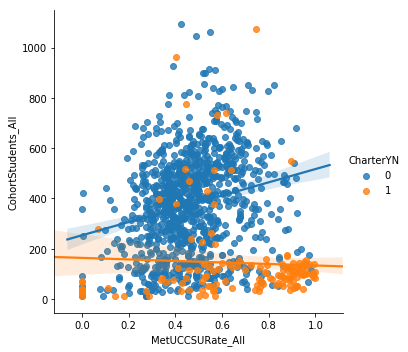

In [454]:
sns.lmplot(data = HS_sub, x = 'MetUCCSURate_All', y = 'CohortStudents_All', hue = 'CharterYN')


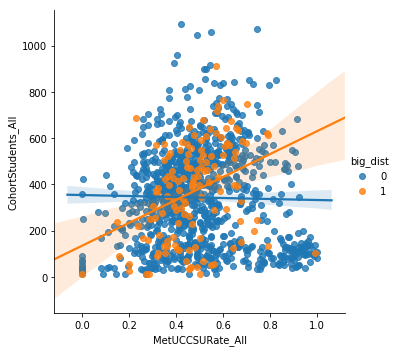

In [455]:
sns.lmplot(data = HS_sub, x = 'MetUCCSURate_All', y = 'CohortStudents_All', hue = 'big_dist')


In [456]:
# created a variable that represents the percentage of the 12th grade who are ELs
x = []
for ik in range(len(HS_sub)):
    x.append(HS_sub['Total_EL_12'][ik]/HS_sub['CohortStudents_All'][ik])

HS_sub['EL_GR12_rate'] = x

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


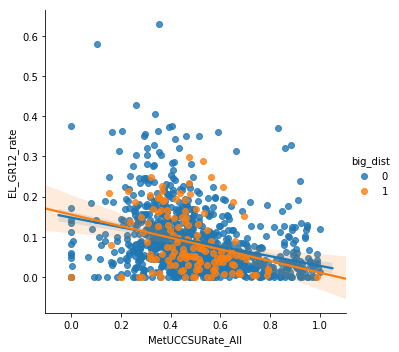

In [457]:
sns.lmplot(data = HS_sub, x = 'MetUCCSURate_All', y = 'EL_GR12_rate', hue = 'big_dist')


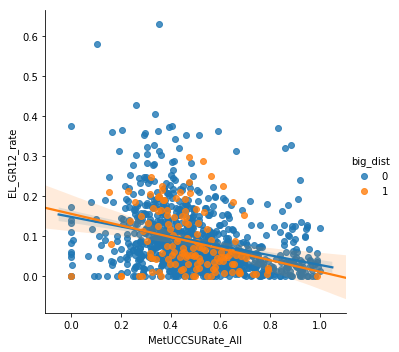

In [458]:
sns.lmplot(data = HS_sub, x = 'MetUCCSURate_All', y = 'EL_GR12_rate', hue = 'big_dist')


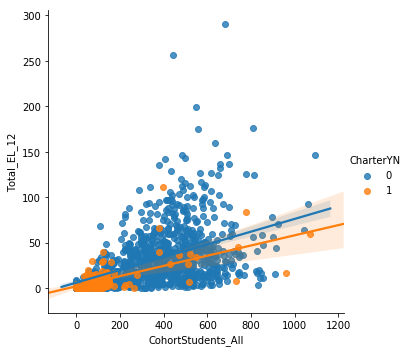

In [459]:
sns.lmplot(data = HS_sub, x = 'CohortStudents_All', y = 'Total_EL_12', hue = 'CharterYN')


In [430]:
HS3 = HS2
threshold = 0.2

# HS3 = HS3.drop(['NCESDist', 'NCESSchool', 'ClosedDate','DOC','SOC'], axis= 1)
HS3 = HS3.drop(HS3.std()[HS3.std() < threshold].index.values, axis=1)
HS3.drop(non_numeric + ["MetUCCSURate_All"], axis=1).apply(lambda x: x.corr(HS3.MetUCCSURate_All)).sort_values(ascending = False)



In [434]:
HS3 = HS2
non_numeric = ['StatusType', 'County', 'District', 'School', 'City', 'Zip', 'OpenDate',
       'Charter', 'CharterNum', 'FundingType', 'DOCType', 'SOCType',
       'EdOpsCode', 'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved',
       'Virtual', 'Magnet', 'Latitude', 'Longitude', 'CharterYN']

non_numeric = ['District', 'OpenDate', 'GSoffered','GSserved']

HS3.drop(non_numeric + ["MetUCCSURate_All"], axis=1).apply(lambda x: x.corr(HS3.MetUCCSURate_All)).sort_values(ascending = False)


/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


MetUCCSURate_TA               0.976376
MetUCCSURate_GF               0.955825
MetUCCSURate_GM               0.949007
MetUCCSURate_SS               0.849399
MetUCCSURate_RH               0.815025
MetUCCSURate_SD               0.531043
MetUCCSURate_SE               0.477528
MetUCCSURate_RW               0.456218
MetUCCSUCount_SD              0.436970
MetUCCSUCount_GM              0.431773
MetUCCSUCount_All             0.391319
MetUCCSUCount_TA              0.391284
MetUCCSUCount_RW              0.365361
CharterYN                     0.355472
MetUCCSURate_RT               0.352674
MetUCCSUCount_GF              0.349656
MetUCCSUCount_RT              0.340229
RegularHSGradRate_TA          0.333662
RegularHSGradRate_All         0.329043
MetUCCSURate_RA               0.323728
MetUCCSUCount_RA              0.321140
RegularHSGradRate_GF          0.317065
RegularHSGradCount_RA         0.276634
RegularHSGradRate_GM          0.270559
CohortStudents_RA             0.269470
RegularHSGradCount_RT    

In [259]:
HS3.CharterYN

CDS
01100170112607    Yes
01611190130229     No
01611190130625    Yes
01611270130450     No
01611430131177     No
01611500132225     No
01611680132746     No
01611760130062     No
01611760134270     No
01611760134452     No
01611760135244     No
01611760138693     No
01611920108670    Yes
01611920127944    Yes
01611920133629     No
01611920135319     No
01611920138339     No
01612000133397     No
01612000134536     No
01612340130054     No
01612420134668     No
01612590100065    Yes
01612590100701     No
01612590108944    Yes
01612590110189     No
01612590111856    Yes
01612590114868    Yes
01612590115238    Yes
01612590125161     No
01612590125716     No
                 ... 
56725205634076     No
56725460120634    Yes
56725460131698    NaN
56725465630389     No
56725465631619     No
56725465631742     No
56725465632849     No
56725465634548     No
56725465634761     No
56726035630322     No
56726035635008     No
56726035636188     No
56726525630348     No
56726525630793     No
567265

In [257]:
HS3.columns[:50]

Index(['StatusType', 'County', 'District', 'School', 'City', 'Zip', 'OpenDate',
       'Charter', 'CharterNum', 'FundingType', 'DOCType', 'SOCType',
       'EdOpsCode', 'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved',
       'Virtual', 'Magnet', 'Latitude', 'Longitude', 'GSoffered_min',
       'CharterYN', 'CohortStudents_GF', 'RegularHSGradCount_GF',
       'RegularHSGradRate_GF', 'MetUCCSUCount_GF', 'MetUCCSURate_GF',
       'DropoutCount_GF', 'DropoutRate_GF', 'CohortStudents_GM',
       'RegularHSGradCount_GM', 'RegularHSGradRate_GM', 'MetUCCSUCount_GM',
       'MetUCCSURate_GM', 'DropoutCount_GM', 'DropoutRate_GM',
       'CohortStudents_GN', 'RegularHSGradCount_GN', 'RegularHSGradRate_GN',
       'MetUCCSUCount_GN', 'MetUCCSURate_GN', 'DropoutCount_GN',
       'DropoutRate_GN', 'CohortStudents_RA', 'RegularHSGradCount_RA',
       'RegularHSGradRate_RA', 'MetUCCSUCount_RA', 'MetUCCSURate_RA'],
      dtype='object')